In [1]:
# Get metadata object
import json
meta_data_file_path = "/fb-agios-acai-efs/Ego4D/ego4d_data/ego4d.json"

with open(meta_data_file_path, 'r') as meta_data_file:
    meta_data_obj = json.load(meta_data_file)

In [2]:
l1_keys = [k for k in meta_data_obj.keys()]
print(f"L1={l1_keys}")

for l1_key in l1_keys:
    child = meta_data_obj[l1_key]
    if isinstance(child, dict):
        print(f"L2={l1_key}:{list(subdict.keys())}")
    elif isinstance(child, list) and isinstance(child[0],dict):
        print(f"L2={l1_key}:{list(child[0].keys())}")
print(f"we are interested in linking per-user with 'fb_participant_id' in 'videos'")

L1=['date', 'version', 'description', 'videos', 'clips', 'concurrent_video_sets', 'physical_settings', 'moments_labels']
L2=videos:['video_uid', 'duration_sec', 'scenarios', 'video_metadata', 'split_em', 'split_av', 'split_fho', 's3_path', 'manifold_path', 'origin_video_id', 'video_source', 'device', 'physical_setting_name', 'fb_participant_id', 'is_stereo', 'has_imu', 'has_gaze', 'imu_metadata', 'gaze_metadata', 'video_components', 'concurrent_sets', 'has_redacted_regions', 'redacted_intervals', 'gaps']
L2=clips:['clip_uid', 'video_uid', 'video_start_sec', 'video_end_sec', 'video_start_frame', 'video_end_frame', 'clip_metadata', 's3_path', 'manifold_path']
L2=concurrent_video_sets:['concurrent_video_set_id', 'valid', 'videos']
L2=physical_settings:['name', 'fb_physical_setting_id', 'source', 's3_path']
L2=moments_labels:['label', 'primary']
we are interested in linking per-user with 'fb_participant_id' in 'videos'


In [3]:
# Collect videos stats
from collections import defaultdict
from collections import OrderedDict

videos = meta_data_obj['videos']

def percent(num,denom):
    return float("{:.1f}".format(num/denom*100))

def nb_format(el_list,d=2):
    fmt = f'{{:.{d}f}}'
    return list(map(
        lambda x: float(fmt.format(x)) if isinstance(x,float) else x,
    el_list))
    
class UserData:
    def __init__(self):
        self.videos = []

# Collect vids per user
user_dict = OrderedDict()
for video in videos:
    user_id = str(video['fb_participant_id']) # Can be null
    user_dict.setdefault(user_id,UserData()).videos.append(video)

total_nb_videos = len(videos)

# Extract NULL user (unassigned)
non_int_users = []
for user_id in user_dict.keys():
    try:
        int(user_id)
    except:
        non_int_users.append(user_id)
print(f"NON-INT USERS: {non_int_users} -> Assumed unassigned")
for non_int_user in non_int_users:
    print("UNKOWN USER VIDEOS:{}/{} ({}%)".format(
          len(user_dict[non_int_user].videos),total_nb_videos,
          percent(len(user_dict[non_int_user].videos),total_nb_videos))
         )

nb_users = len(user_dict.keys()) - len(non_int_users)
print(f"NB of ASSIGNED USERS: {nb_users}")
    

NON-INT USERS: ['None'] -> Assumed unassigned
UNKOWN USER VIDEOS:1478/9645 (15.3%)
NB of ASSIGNED USERS: 813


In [4]:
# HELPER FUNCTIONS
import matplotlib.pyplot as plt
import numpy as np

# Barchart API: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
def plot_barchart(x_axis, sorted_freq, title,ylabel,xlabel='User-ID', grid=False,yerror=None):
    max_val = max(sorted_freq)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=(12, 6), dpi=600) # So all bars are visible!
    plt.bar(x_axis, height=sorted_freq,color=my_cmap.colors, align='edge',yerr=yerror,width=0.9)
    plt.ylim(None,max_val*1.01)
    plt.xlim(None,None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"HEAD = {nb_format(sorted_freq[:10])}...")
    print(f"TAIL = ...{nb_format(sorted_freq[-10:])}")
    

def get_derived_distrs(counts, return_idxs=False,reverse=True):
    """ Return sorted, PDF, CDF, sorted_idxs"""
    s_idxs = np.argsort(counts,axis=0)
    if reverse:
        s_idxs = s_idxs[::-1]
    counts_sorted = np.array(counts)[s_idxs]
    
    # Pdf
    total_video_count = sum(counts_sorted)
    pdf = [cnt/total_video_count for cnt in counts_sorted] # Sorted and normalized
    
    # Cdf
    cdf = [pdf[0]]
    for x in pdf[1:]:
        cdf.append(cdf[-1]+x)
    
    ret = (counts_sorted, pdf, cdf)
    if return_idxs:
        ret = ret + (s_idxs,)
    return ret

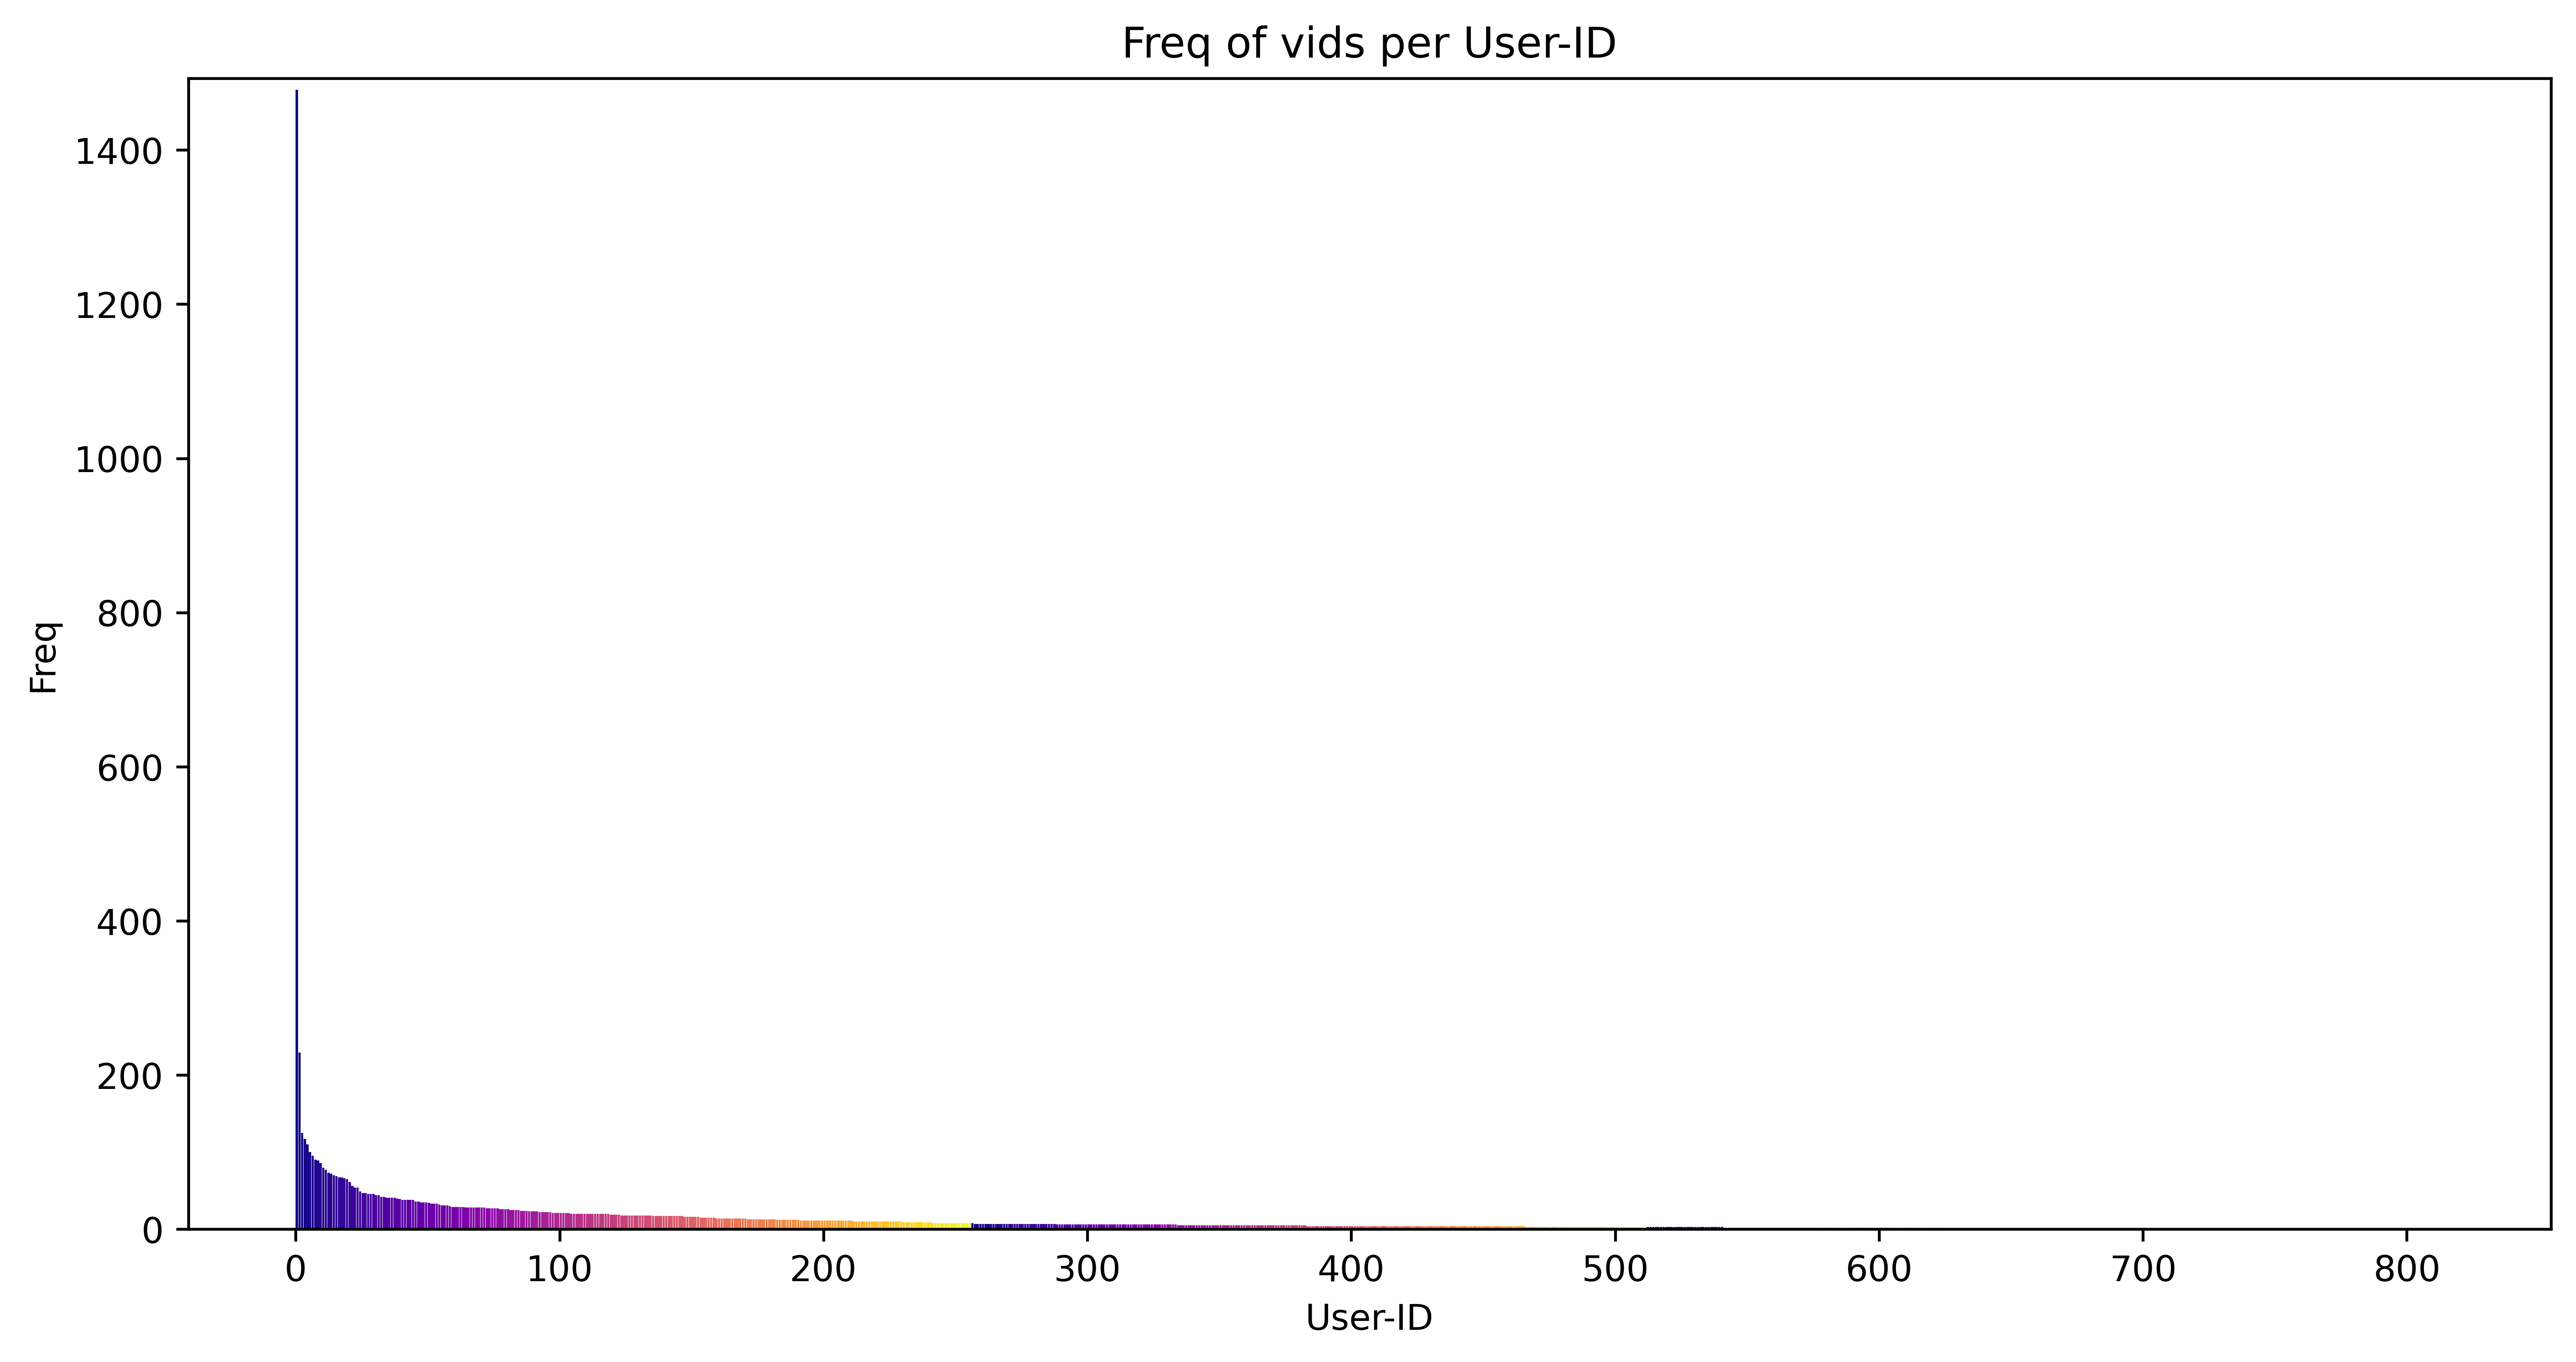

HEAD = [1478, 229, 125, 117, 110, 100, 95, 90, 89, 86]...
TAIL = ...[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
First user is the unassigned one!


<Figure size 432x288 with 0 Axes>

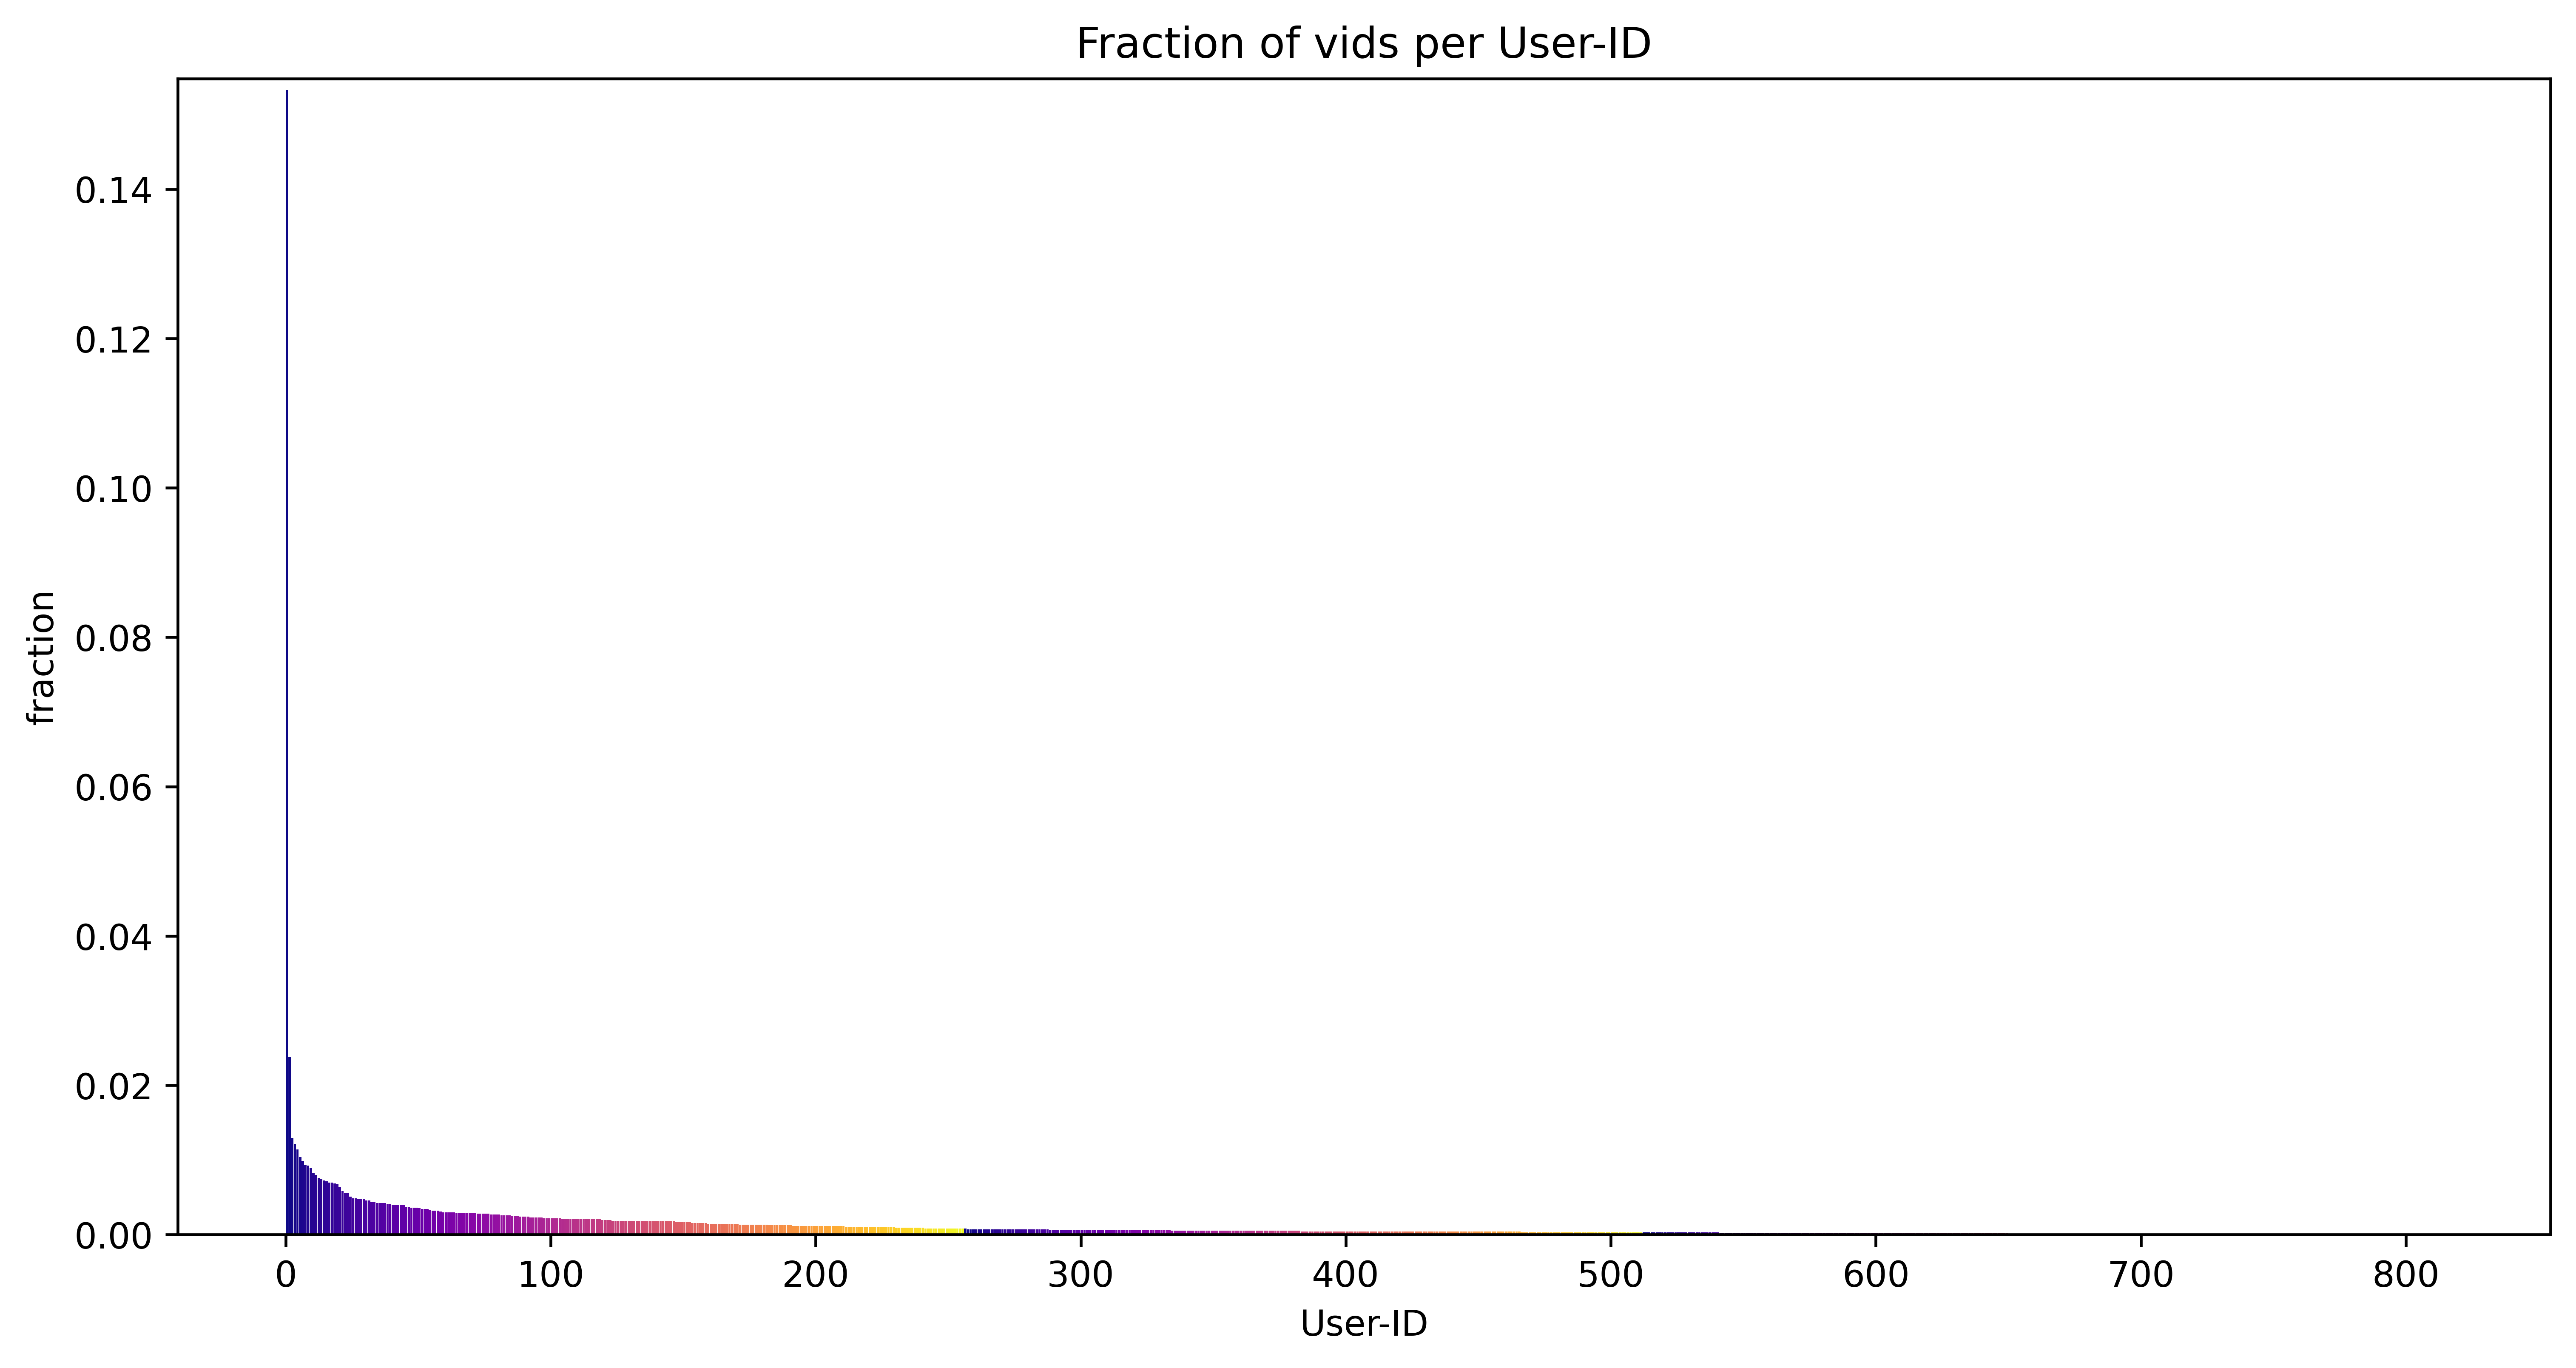

HEAD = [0.15, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]...
TAIL = ...[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Unassigned is 15%, highest user fraction is only nearly 2%


<Figure size 432x288 with 0 Axes>

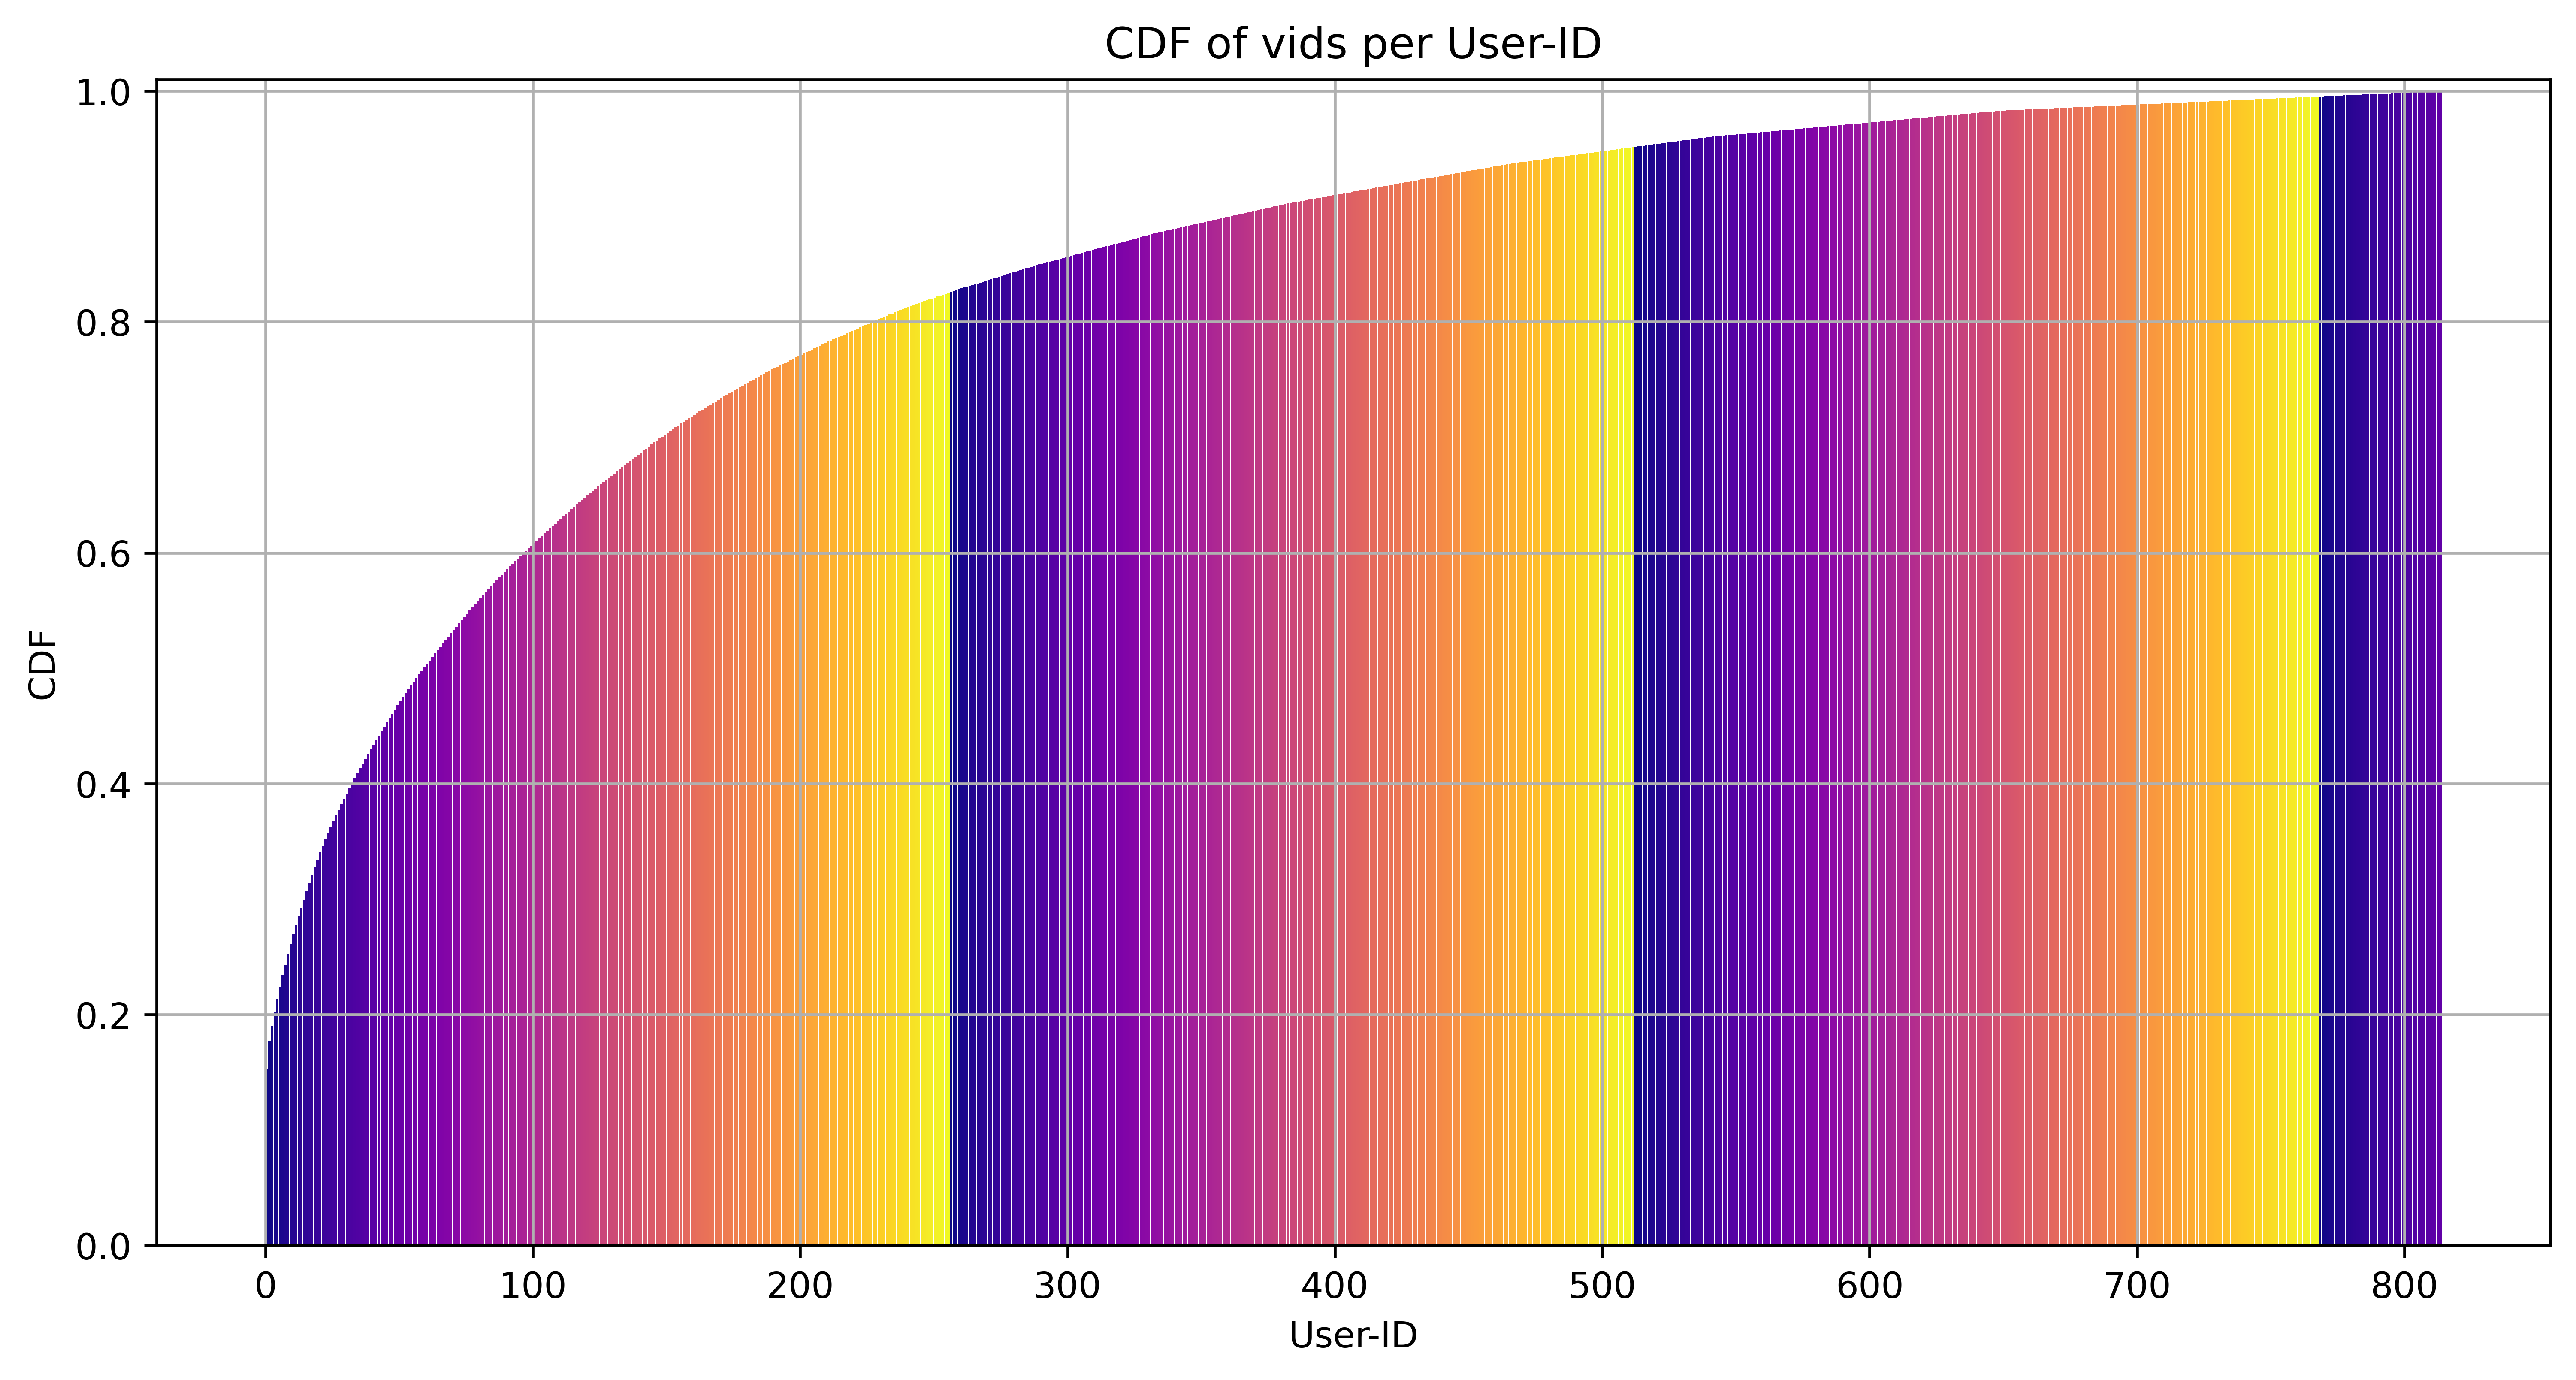

HEAD = [0.15, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26]...
TAIL = ...[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
About 60% of the videos is from the first 100 users
About 80% of the videos is from the first 200 users


<Figure size 432x288 with 0 Axes>

In [5]:
# PLOT VIDEOS PER USER
user_video_count = [len(u.videos) for u in user_dict.values()]
user_video_count_s, user_video_count_sn, user_video_count_snc = get_derived_distrs(user_video_count)
x_axis = [idx for idx in range(len(user_video_count_s))]

# Counts
plot_barchart(x_axis, user_video_count_s, title='Freq of vids per User-ID',ylabel='Freq')
print(f"First user is the unassigned one!")


# Normalized
plot_barchart(x_axis, user_video_count_sn,  title='Fraction of vids per User-ID',ylabel='fraction')
print(f"Unassigned is 15%, highest user fraction is only nearly 2%")

# Cumulative
plot_barchart(x_axis, user_video_count_snc,title='CDF of vids per User-ID',ylabel='CDF', grid=True)
print(f"About 60% of the videos is from the first 100 users")
print(f"About 80% of the videos is from the first 200 users")


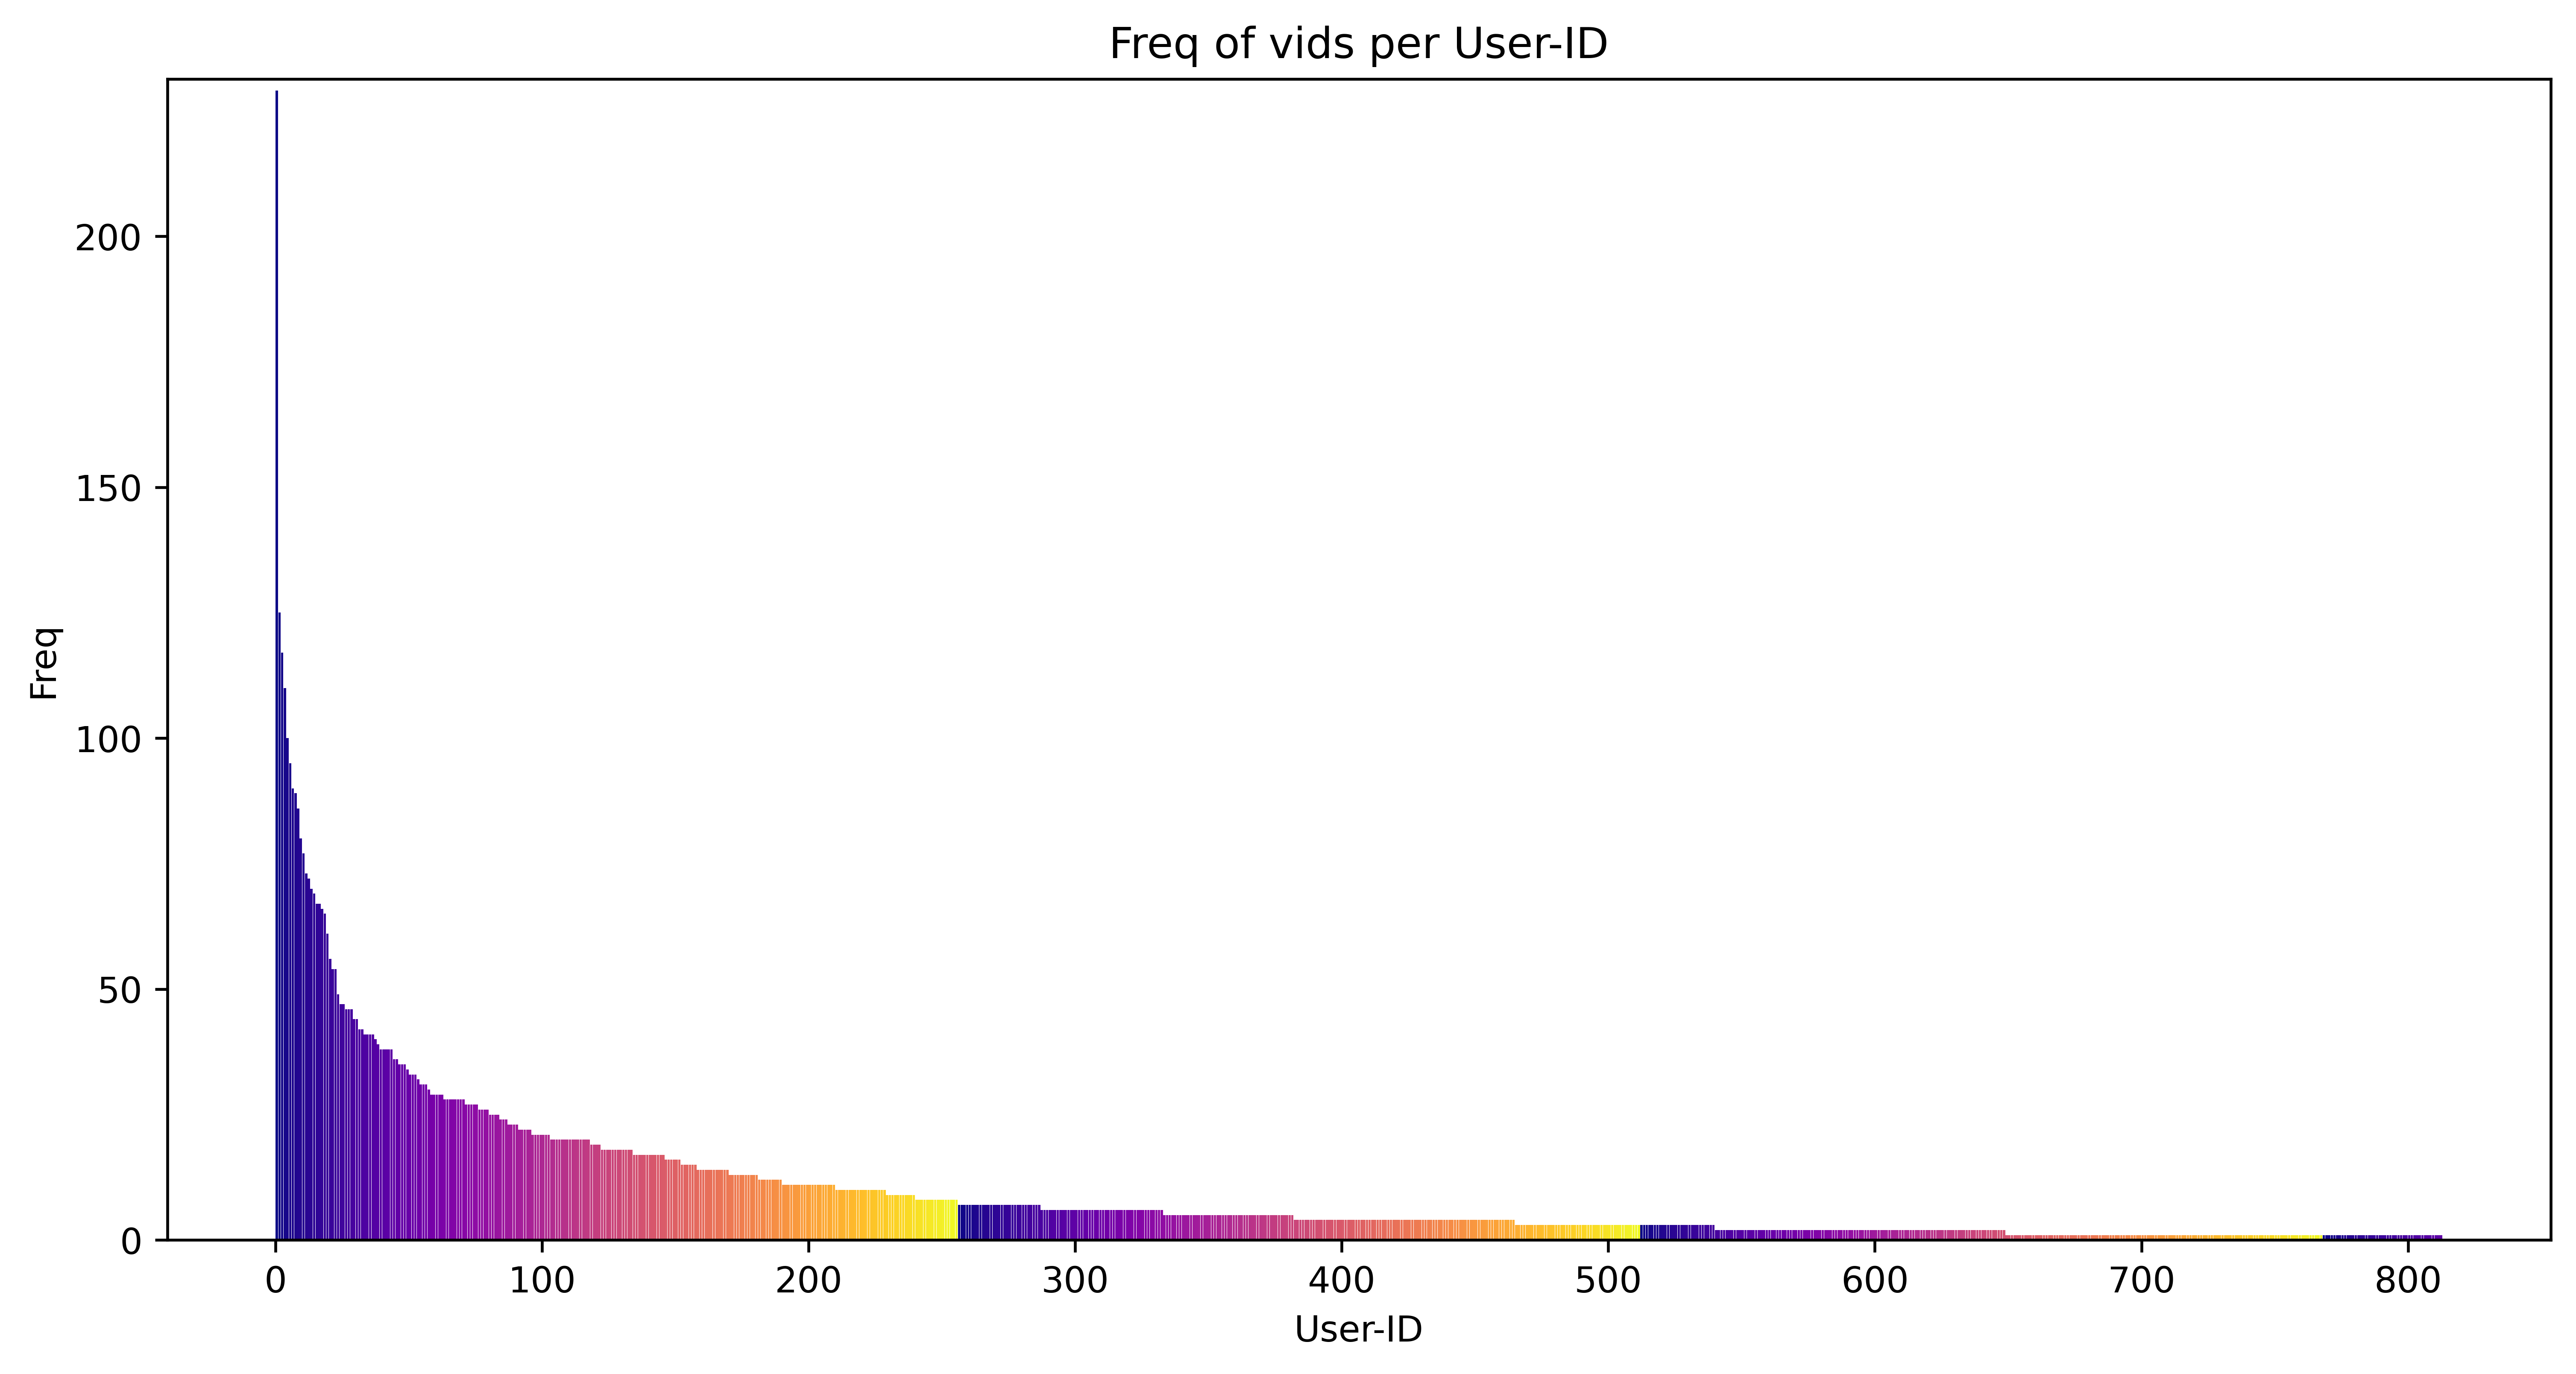

HEAD = [229, 125, 117, 110, 100, 95, 90, 89, 86, 80]...
TAIL = ...[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<Figure size 432x288 with 0 Axes>

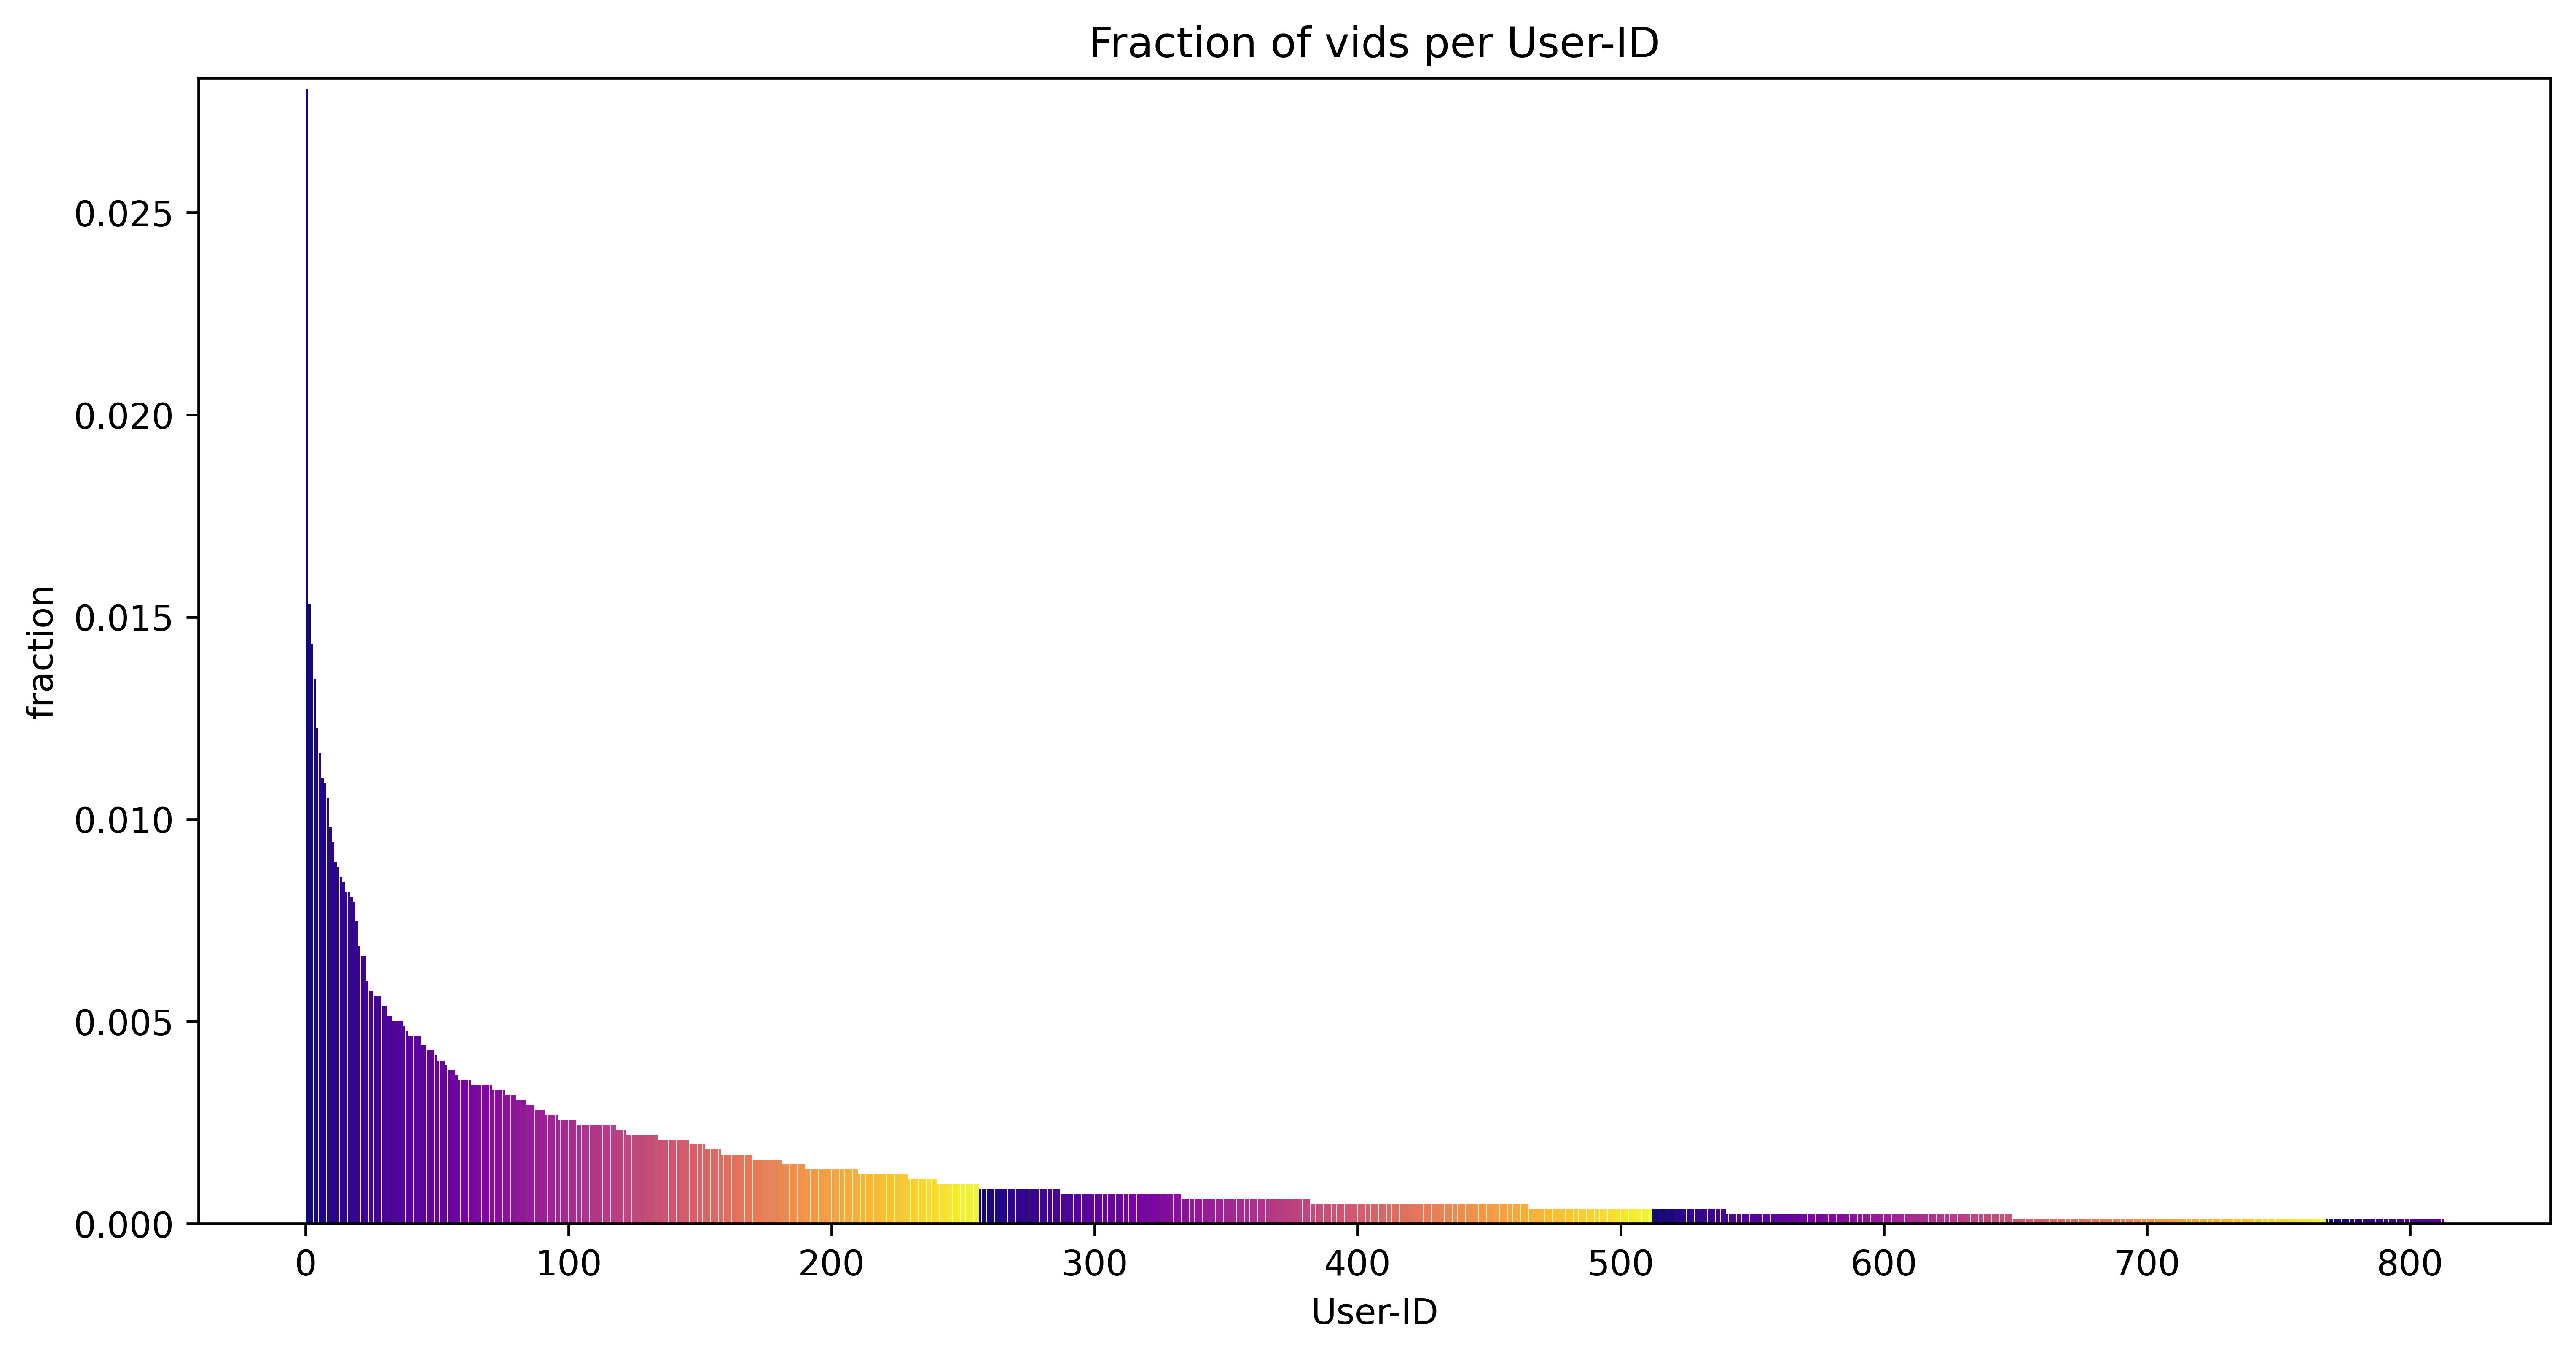

HEAD = [0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]...
TAIL = ...[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Unassigned is 15%, highest user fraction is only nearly 2%


<Figure size 432x288 with 0 Axes>

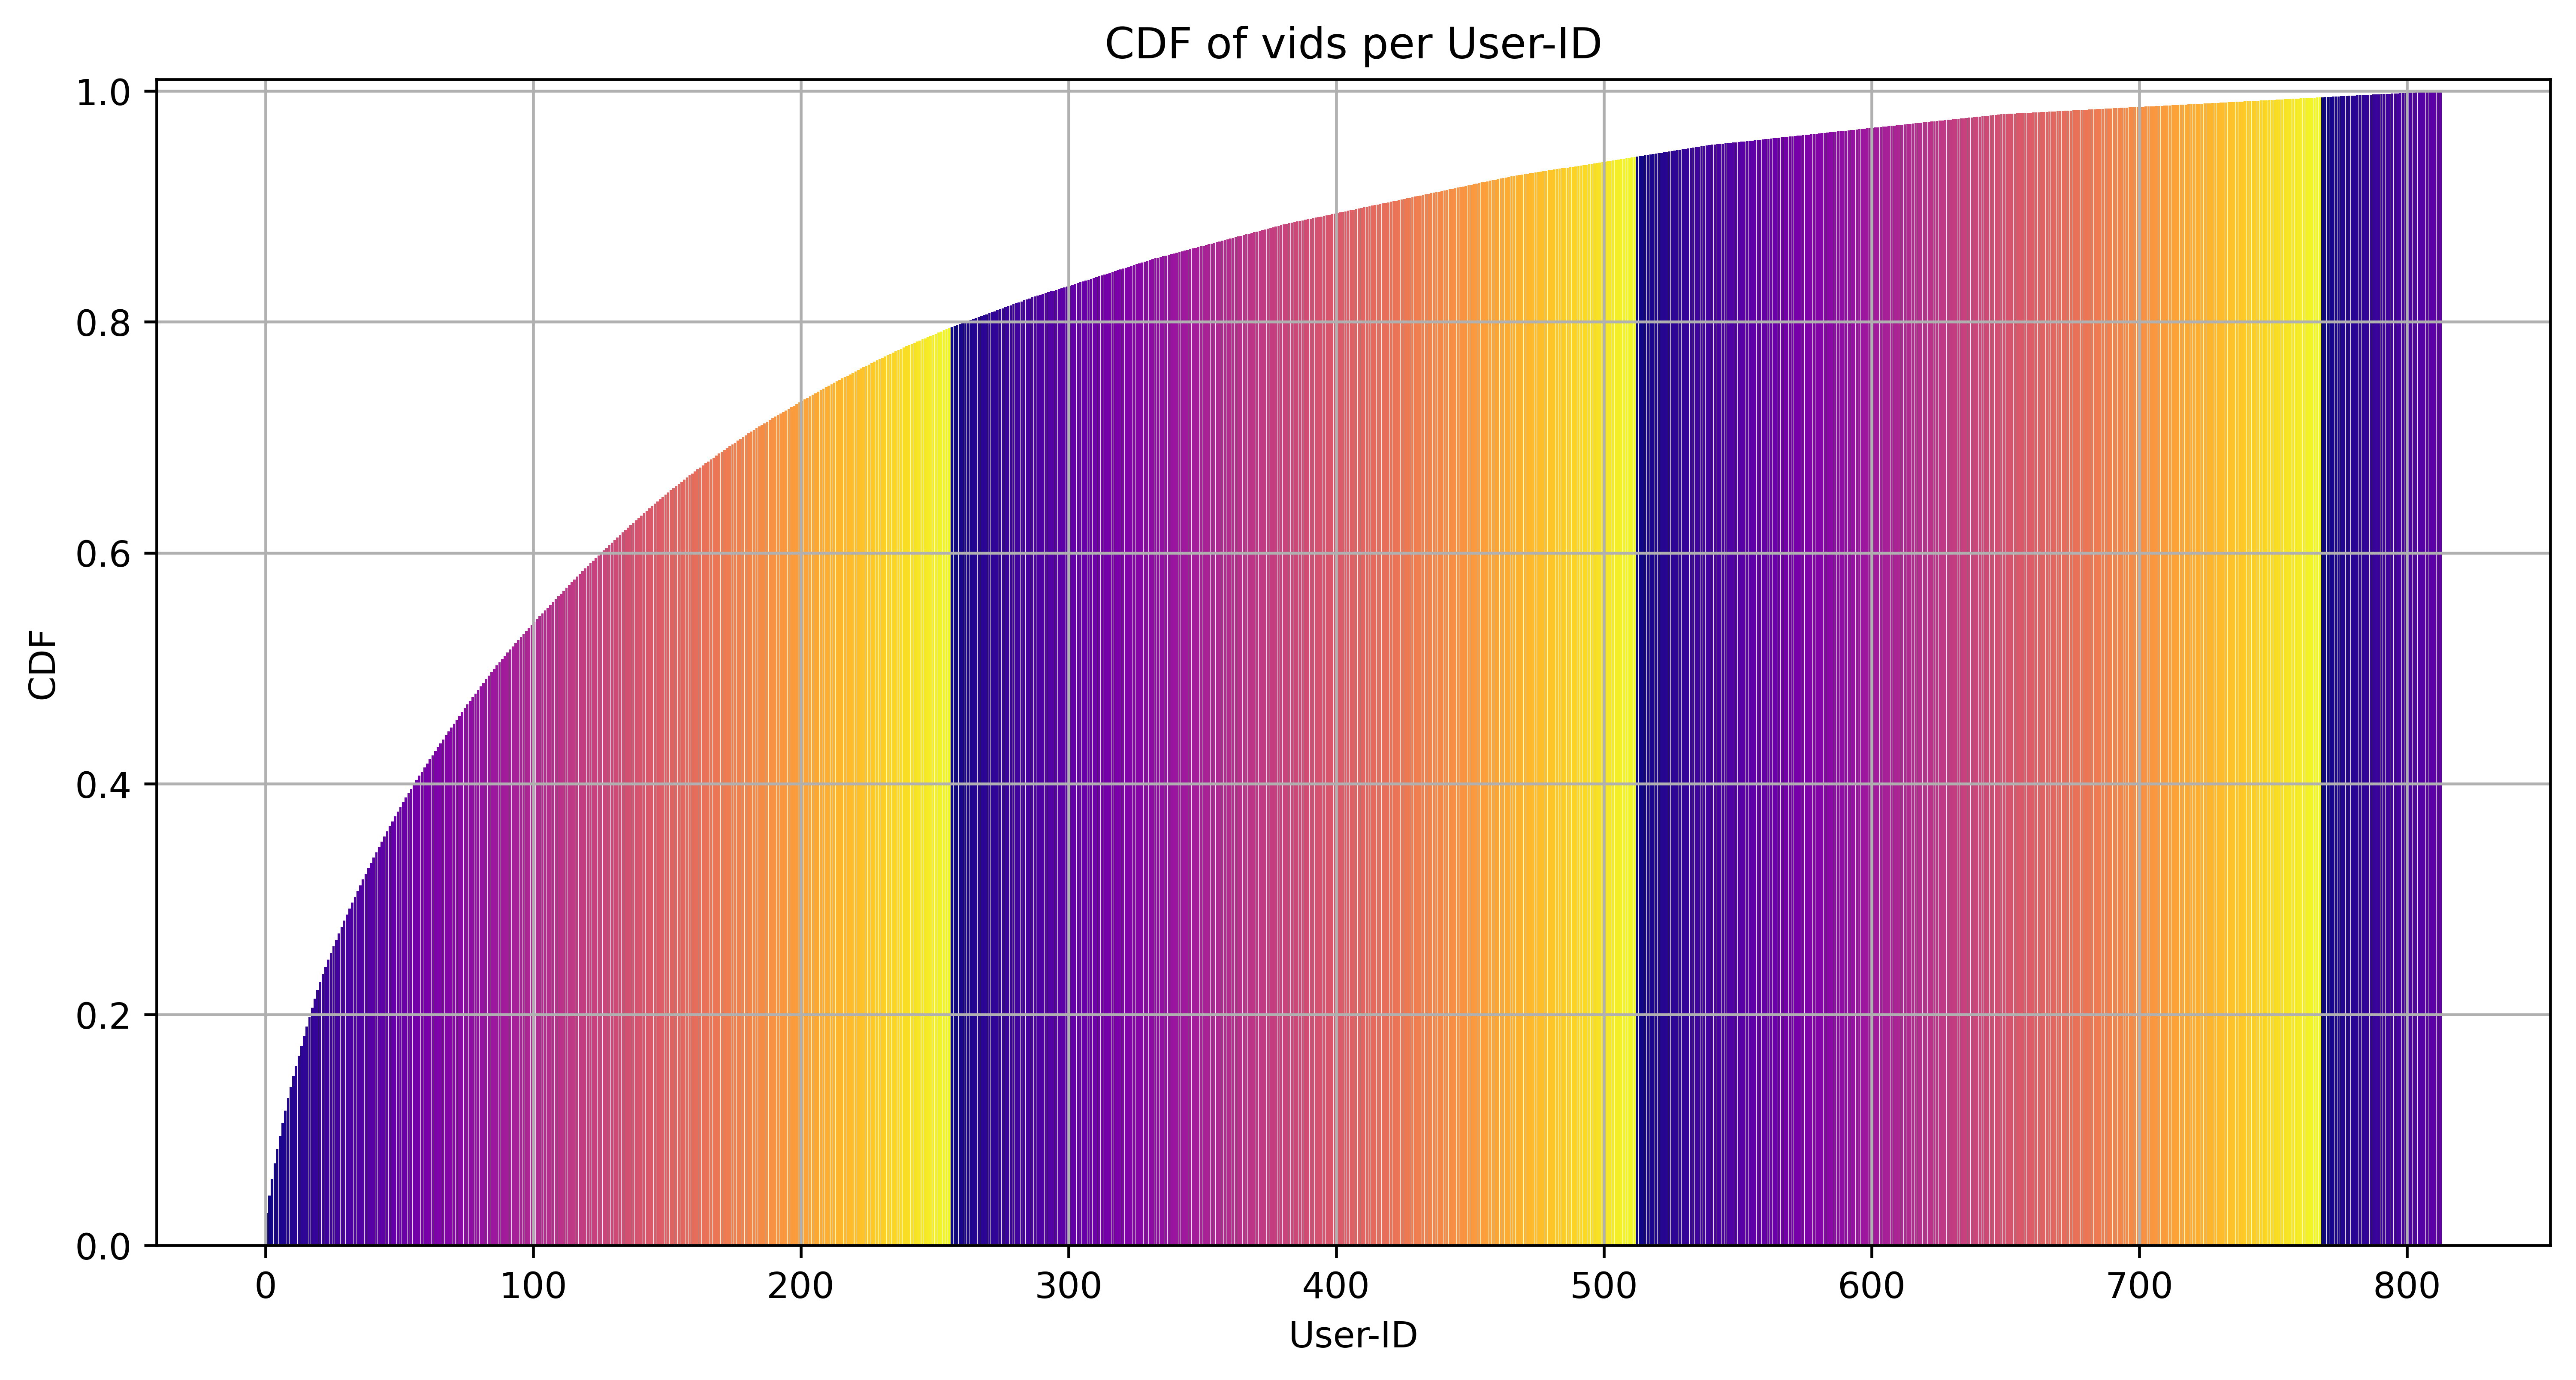

HEAD = [0.03, 0.04, 0.06, 0.07, 0.08, 0.1, 0.11, 0.12, 0.13, 0.14]...
TAIL = ...[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Over 50% of the videos is from the first 100 users
About 80% of the videos is from the first 250 users


<Figure size 432x288 with 0 Axes>

In [6]:
# Now let's do the same without the unassigned videos

# Renew devision factor
user_video_count = [len(u.videos) for k, u in user_dict.items() if k not in non_int_users]
excl_x_axis = x_axis[:-1]
excl_user_video_count_s, excl_user_video_count_sn, excl_user_video_count_snc, excl_user_video_count_idxs = get_derived_distrs(user_video_count,return_idxs=True)

# Histogram
plot_barchart(excl_x_axis, excl_user_video_count_s, title='Freq of vids per User-ID',ylabel='Freq')

# Normalized
plot_barchart(excl_x_axis, excl_user_video_count_sn,  title='Fraction of vids per User-ID',ylabel='fraction')
print(f"Unassigned is 15%, highest user fraction is only nearly 2%")

# Cumulative
plot_barchart(excl_x_axis, excl_user_video_count_snc,title='CDF of vids per User-ID',ylabel='CDF', grid=True)
print(f"Over 50% of the videos is from the first 100 users")
print(f"About 80% of the videos is from the first 250 users")

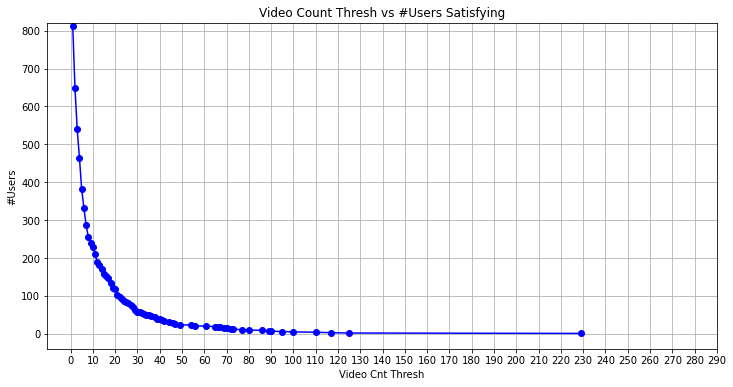

HEAD = [229, 125, 117, 110, 100, 95, 90, 89, 86, 80]...
TAIL = ...[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


<Figure size 432x288 with 0 Axes>

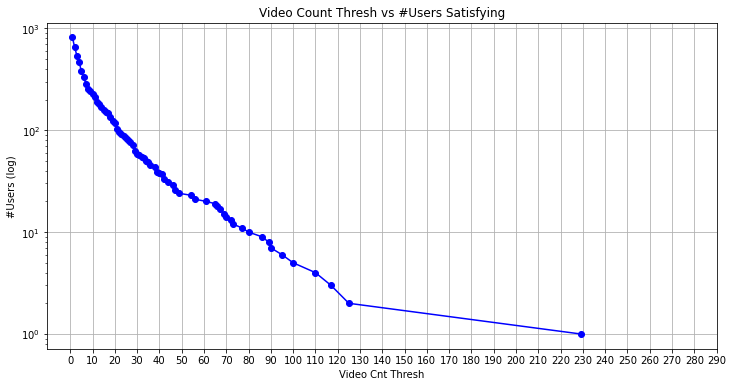

HEAD = [229, 125, 117, 110, 100, 95, 90, 89, 86, 80]...
TAIL = ...[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
10 users have >=80 videos
100 users have >=20 videos
200 users have >=10 videos


<Figure size 432x288 with 0 Axes>

In [7]:
# Make ROC curve with changing threshold and how many users are left
# NOT INCLUDING unassigned vids
import math

user_video_count = sorted([len(u.videos) for k, u in user_dict.items() if k not in non_int_users],reverse=True)
min_val, max_val = user_video_count[-1], user_video_count[0]


def plot_line(x_axis, vals, title,ylabel,xlabel, grid=False,log=False):
    max_val = max(vals)
#     my_cmap = plt.get_cmap("plasma")
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x_axis, vals,color='b',marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log:
        plt.yscale('log')
    else:
        plt.ylim(None,max_val*1.01)
    
    x_major_ticks = list(range(0,300,10))
    ax.set_xticks(x_major_ticks)
#     ax.set_yticks(major_ticks)

    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"HEAD = {nb_format(x_axis[:10])}...")
    print(f"TAIL = ...{nb_format(x_axis[-10:])}")

# Count unique vid-counts
unique_vidcnt_freqs = []
user_idx = 0
while user_idx < len(user_video_count):
    new_vidcnt = user_video_count[user_idx]
    nb_users = 1
    
    while user_idx + 1 < len(user_video_count) and user_video_count[user_idx + 1] == new_vidcnt:
        nb_users+=1
        user_idx+=1
    
    unique_vidcnt_freqs.append((new_vidcnt, nb_users))
    user_idx+=1 # Next unique vid count

# Now count how many users satisfy threshold, going from highest unique cnts to lowest
# Like CDF, the previous higher ones also satisfy this unique new threshold
unique_vidcnt_cum = [unique_vidcnt_freqs[0]]
for (new_vidcnt, nb_users) in unique_vidcnt_freqs[1:]:
    cum_users = unique_vidcnt_cum[-1][1] + nb_users
    unique_vidcnt_cum.append((new_vidcnt,cum_users))

x_vals = [x[0] for x in unique_vidcnt_cum]
y_vals = [x[1] for x in unique_vidcnt_cum]

plot_line(x_vals,y_vals,title="Video Count Thresh vs #Users Satisfying",xlabel="Video Cnt Thresh",ylabel="#Users",grid=True)

# LOG variant
# log_y_vals = [math.log10(y) for y in y_vals]
plot_line(x_vals,y_vals,title="Video Count Thresh vs #Users Satisfying",xlabel="Video Cnt Thresh",ylabel="#Users (log)",grid=True,log=True)
print(f"10 users have >=80 videos")
print(f"100 users have >=20 videos")
print(f"200 users have >=10 videos")

In [8]:
# User total and avg/std video time
import numpy as np

# Array of vid lengths, derive stats after
user_vid_sec_lists = [[v['duration_sec'] for v in u.videos] for k, u in user_dict.items() if k not in non_int_users]

# total,avg,std
user_totals = [sum(vids_len_list) for vids_len_list in user_vid_sec_lists]
user_avgs, user_stds = [],[]
for vids_len_list in user_vid_sec_lists:
    user_avgs.append(np.mean(vids_len_list))
    user_stds.append(np.std(vids_len_list))

# To minutes
for l in [user_totals,user_avgs,user_stds]:
    for idx in range(len(l)):
        l[idx] = int(l[idx]/60)

# print(user_totals)
# print(user_avgs)
# print(user_stds)    

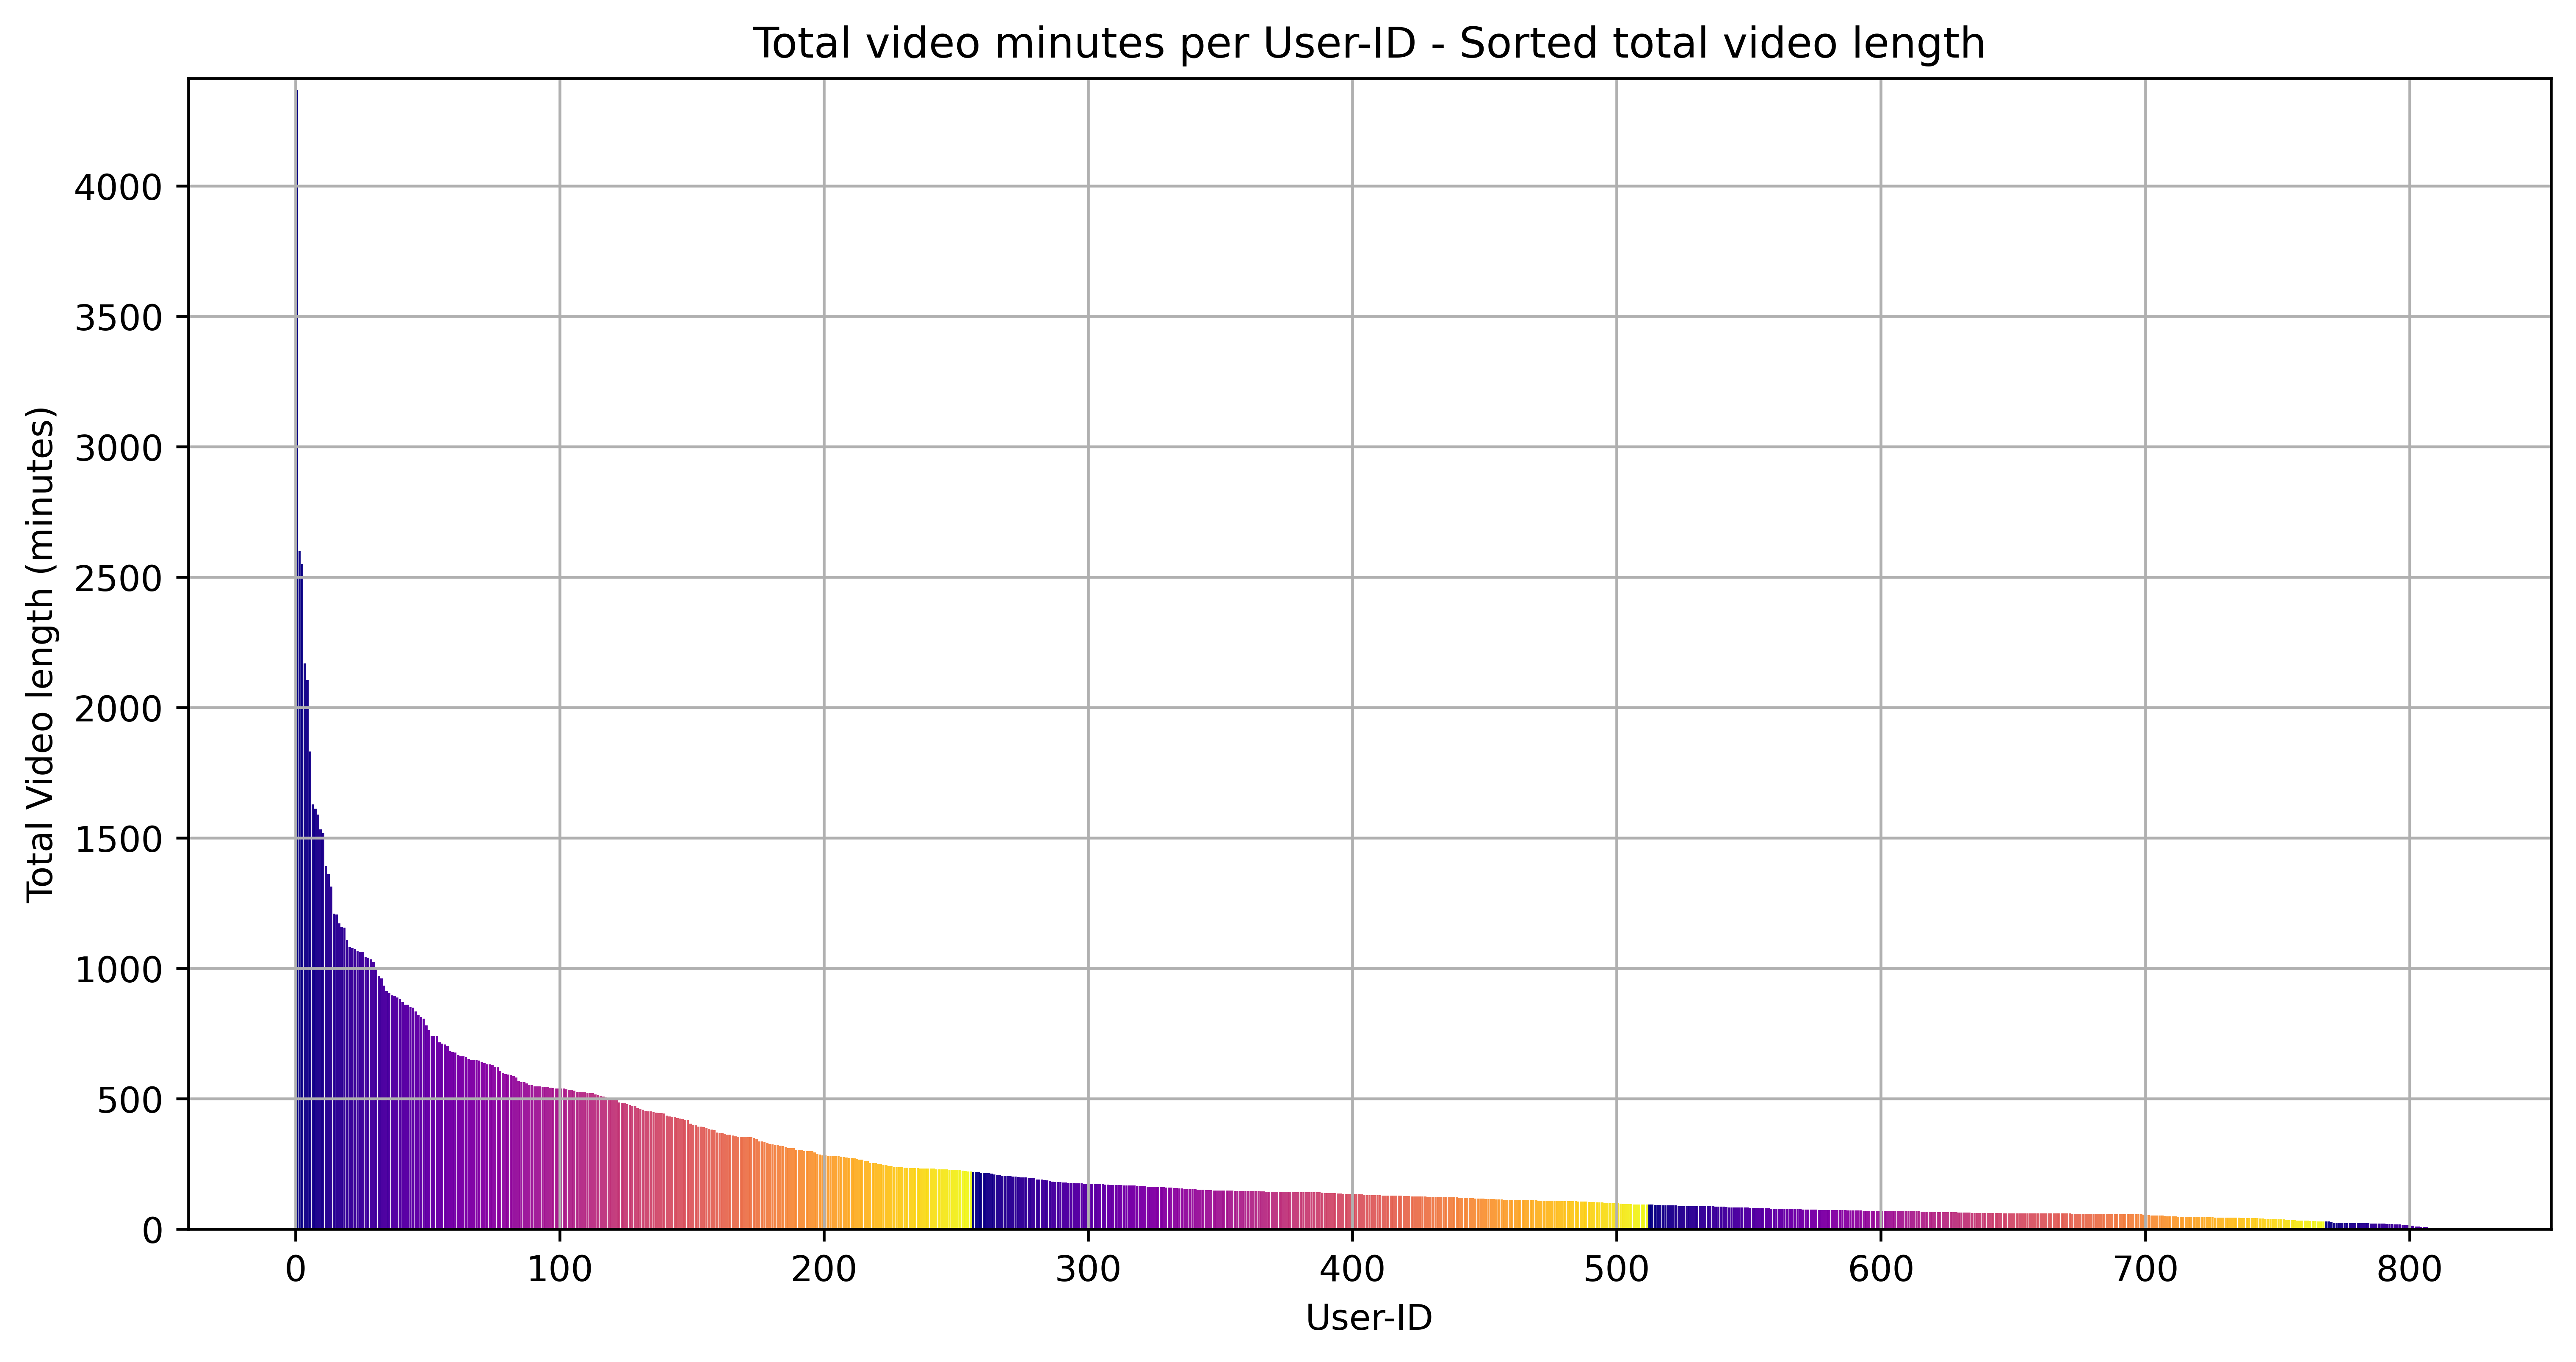

HEAD = [4368, 2599, 2551, 2169, 2105, 1831, 1628, 1613, 1590, 1533]...
TAIL = ...[10, 8, 8, 8, 6, 5, 4, 4, 0, 0]


<Figure size 432x288 with 0 Axes>

In [9]:
# PLOT VIDEO TOTAL LENGTHS PER USER (Not including unassigned)
import matplotlib.pyplot as plt
    
# Get idxs    
user_video_len_s, user_video_len_sn, user_video_len_snc, s_idxs = get_derived_distrs(user_totals,reverse=True,return_idxs=True)
x_axis = [idx for idx in range(len(user_video_len_s))]

# Totals - sorted total video length
plot_barchart(x_axis, user_video_len_s, title='Total video minutes per User-ID - Sorted total video length',ylabel='Total Video length (minutes)',grid=True)


# Normalized
# plot_barchart(x_axis, user_video_len_sn,  title='Fraction of vids per User-ID',ylabel='fraction video length')

# Cumulative
# plot_barchart(x_axis, user_video_len_snc,title='CDF of video seconds per User-ID',ylabel='CDF video fractions', grid=True)


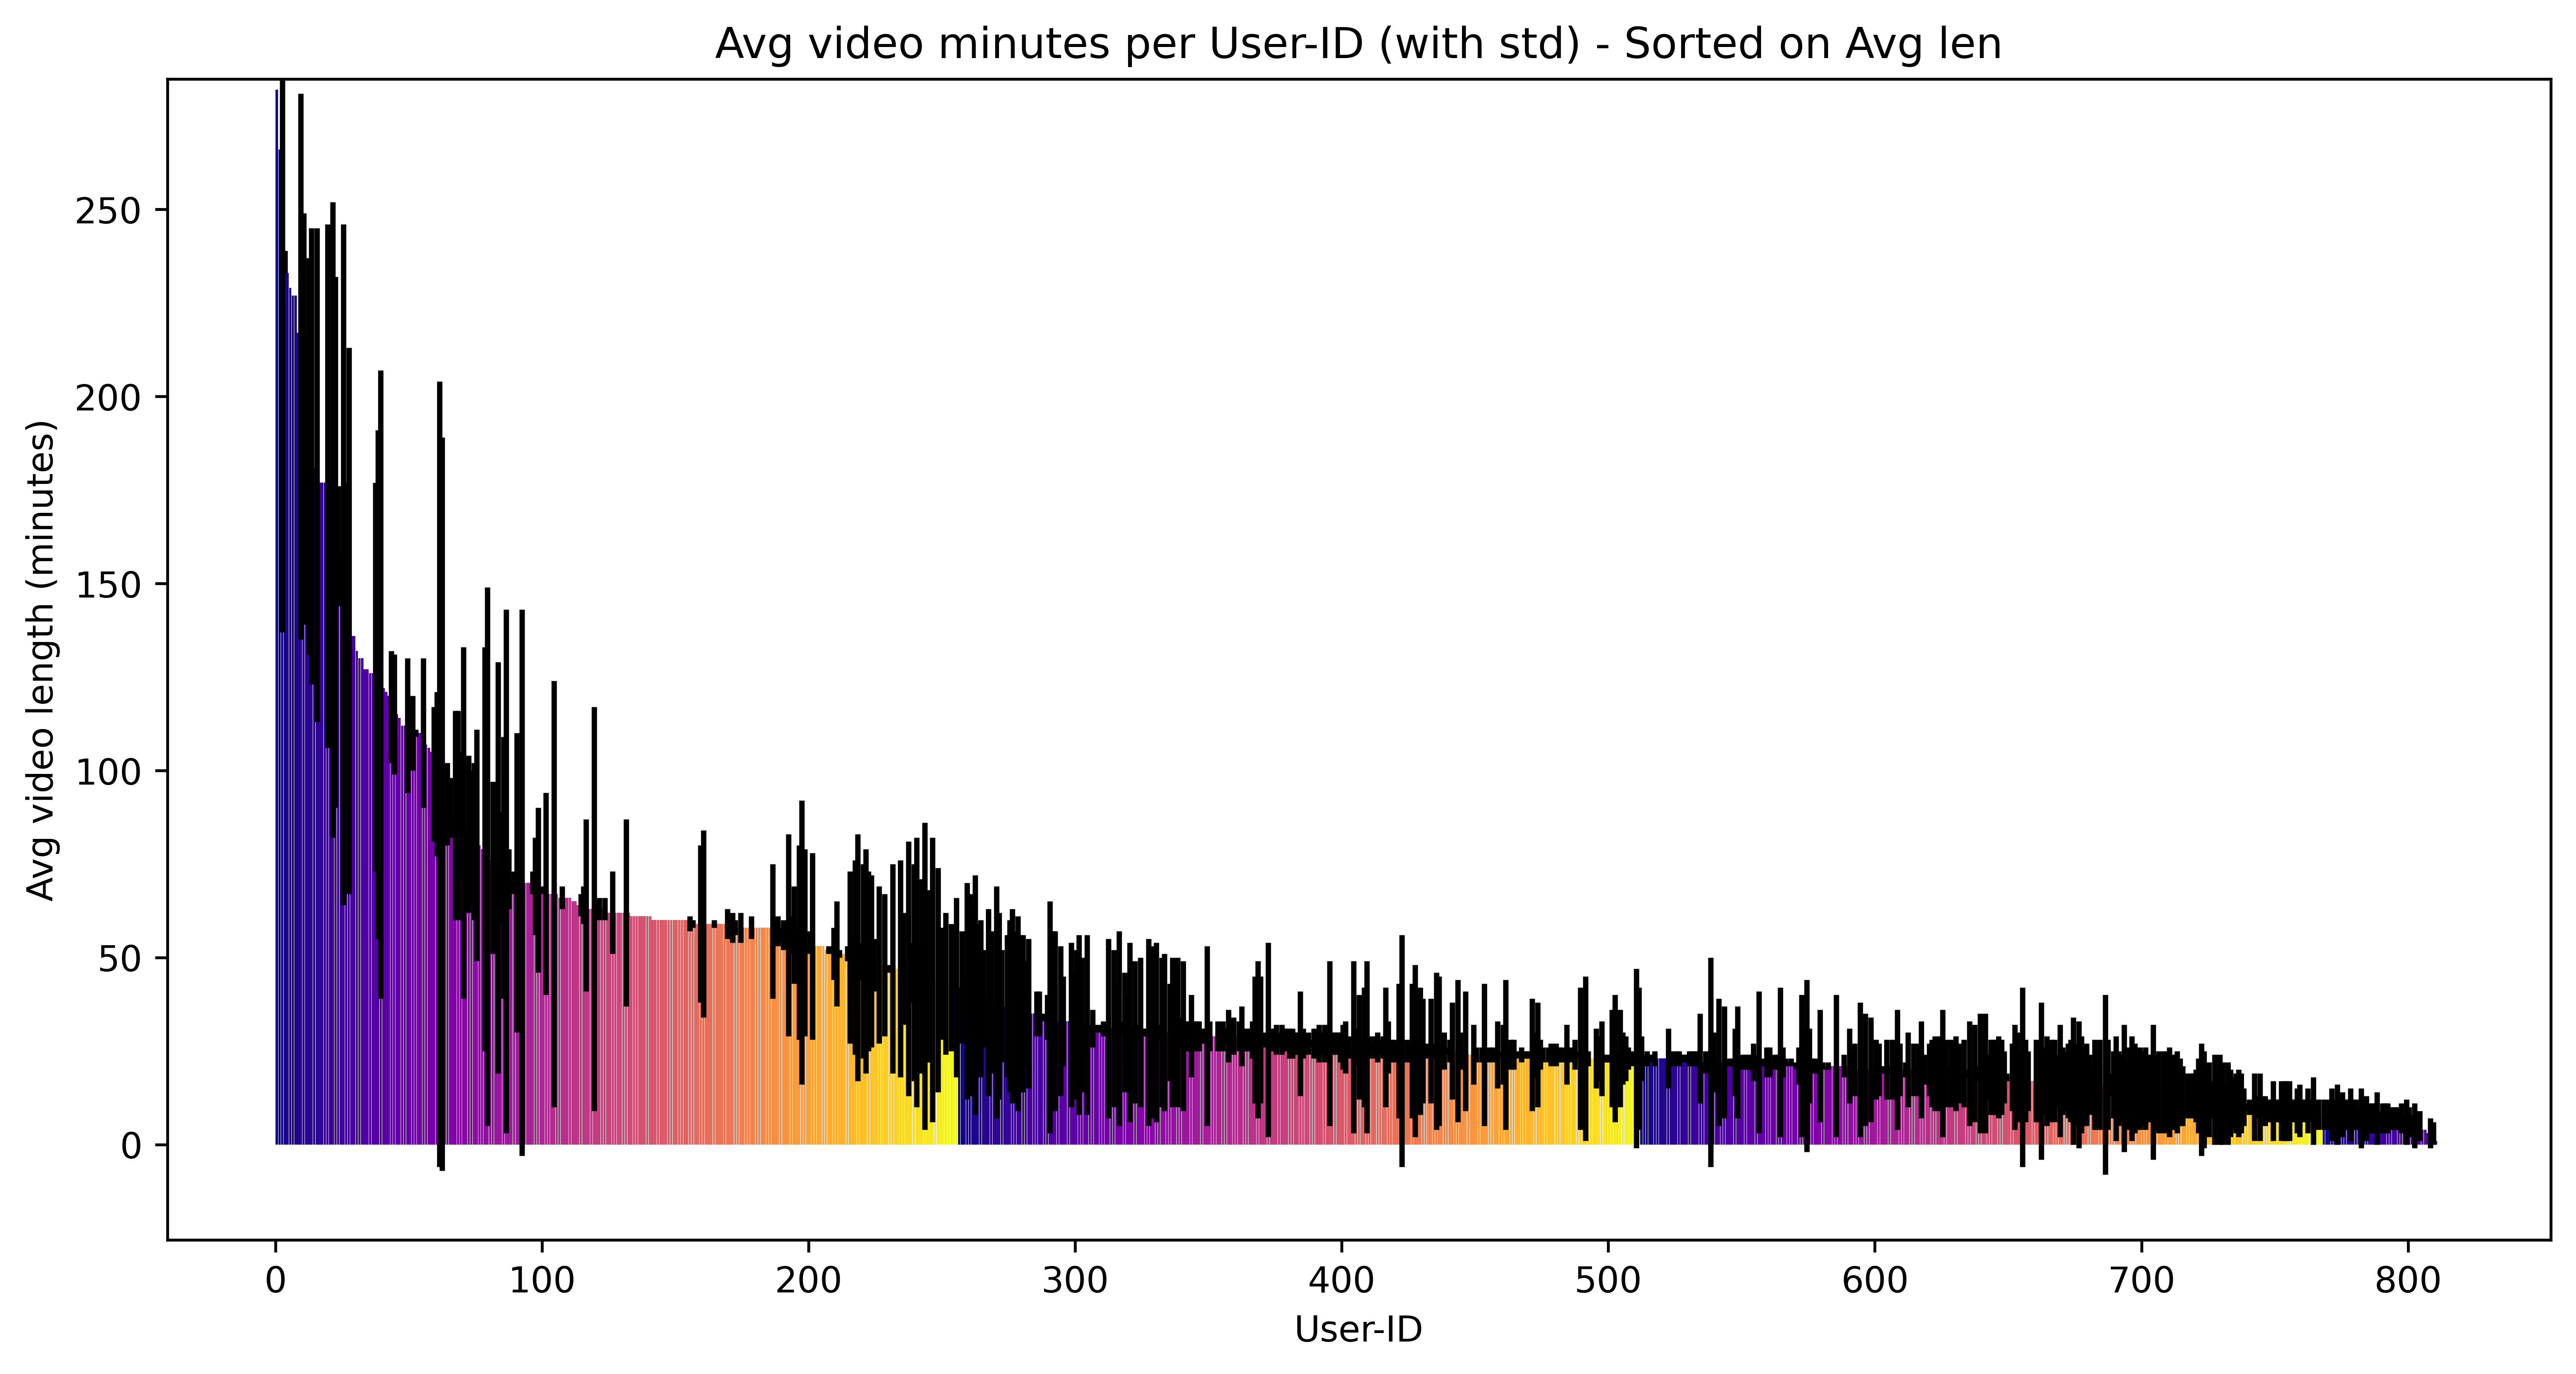

HEAD = [282, 266, 240, 236, 233, 229, 227, 227, 217, 208]...
TAIL = ...[5, 5, 4, 4, 3, 3, 3, 1, 0, 0]


<Figure size 432x288 with 0 Axes>

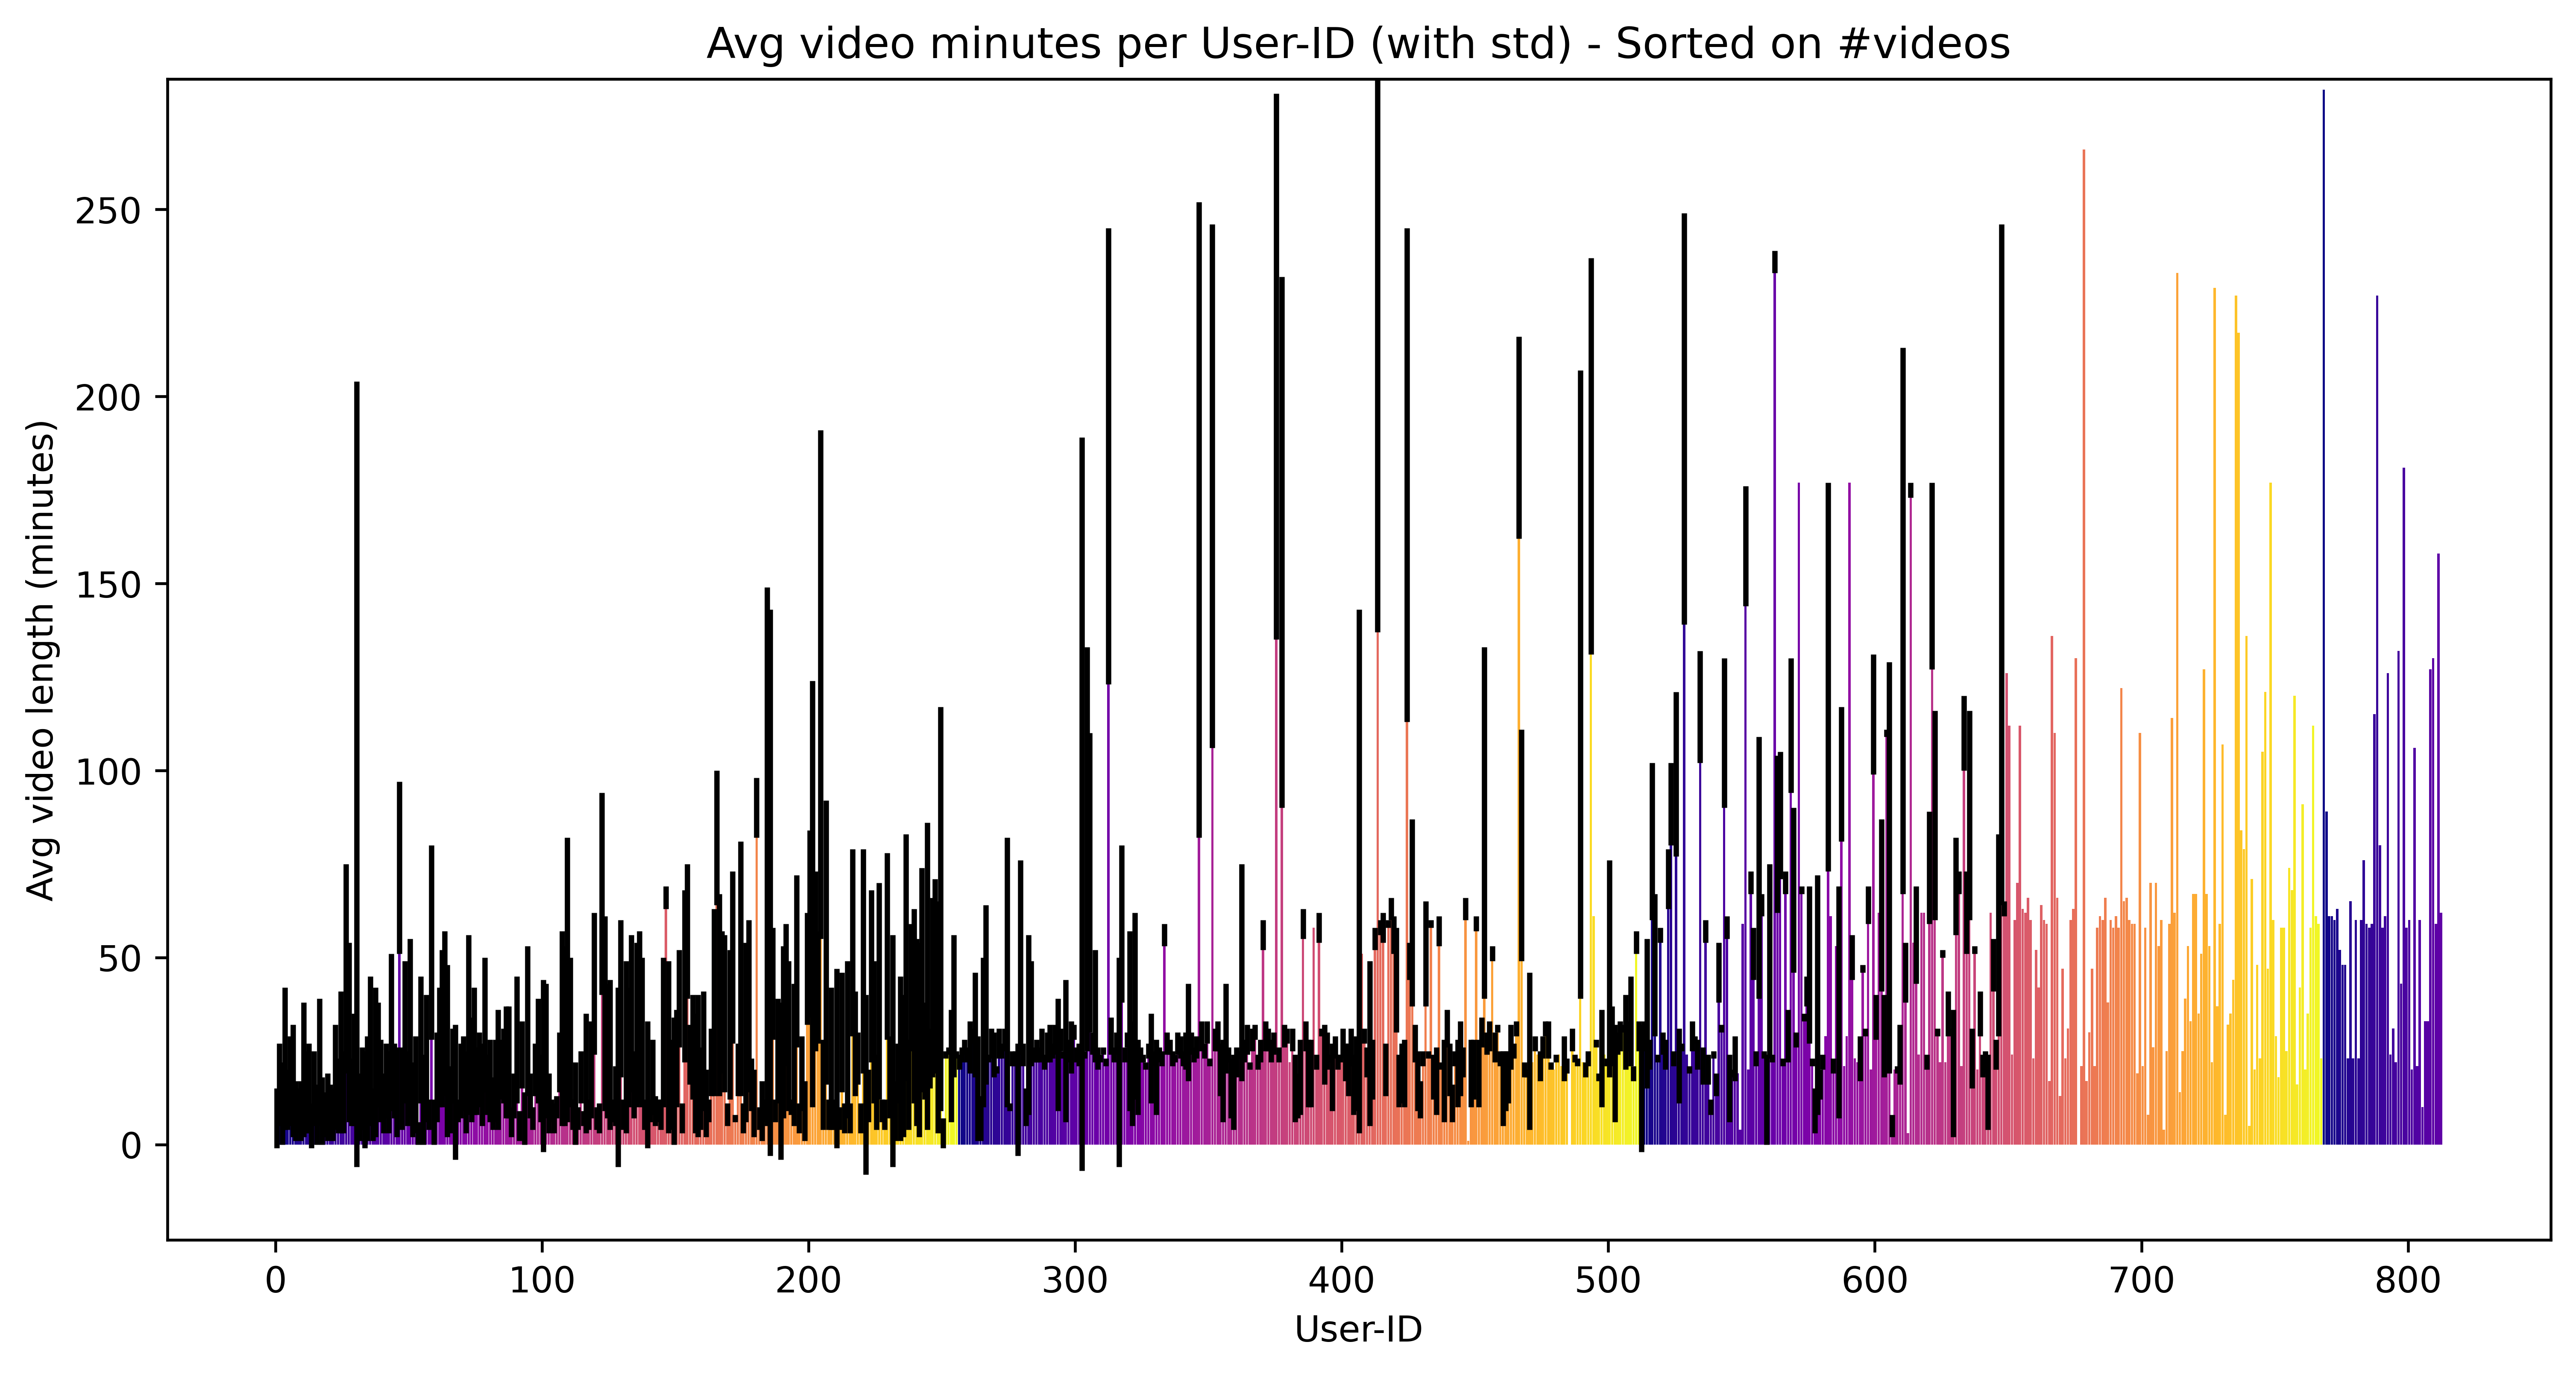

HEAD = [7, 16, 11, 23, 12, 17, 17, 9, 9, 9]...
TAIL = ...[21, 60, 10, 33, 33, 127, 130, 59, 158, 62]
Those with many videos have rather short ones
Those with only 1 video have long ones! (see final 150 users)


<Figure size 432x288 with 0 Axes>

In [10]:
# PLOT VIDEO AVG+STDS LENGTHS PER USER (Not including unassigned)
# Sort on avg video length, and include STD
user_avg_s, user_avg_sn, user_avg_snc, s_idxs = get_derived_distrs(user_avgs,reverse=True,return_idxs=True)
x_axis = [idx for idx in range(len(user_video_len_s))]

user_stds_s = np.array(user_stds)[s_idxs]

# Counts
plot_barchart(x_axis, user_avg_s, title='Avg video minutes per User-ID (with std) - Sorted on Avg len',ylabel='Avg video length (minutes)',yerror=user_stds_s)


user_avg_s_nb_videos = np.array(user_avgs)[excl_user_video_count_idxs]
user_stds_s_nb_videos = np.array(user_stds)[excl_user_video_count_idxs]
plot_barchart(x_axis, user_avg_s_nb_videos, title='Avg video minutes per User-ID (with std) - Sorted on #videos',ylabel='Avg video length (minutes)',yerror=user_stds_s_nb_videos)
print(f"Those with many videos have rather short ones")
print(f"Those with only 1 video have long ones! (see final 150 users)")

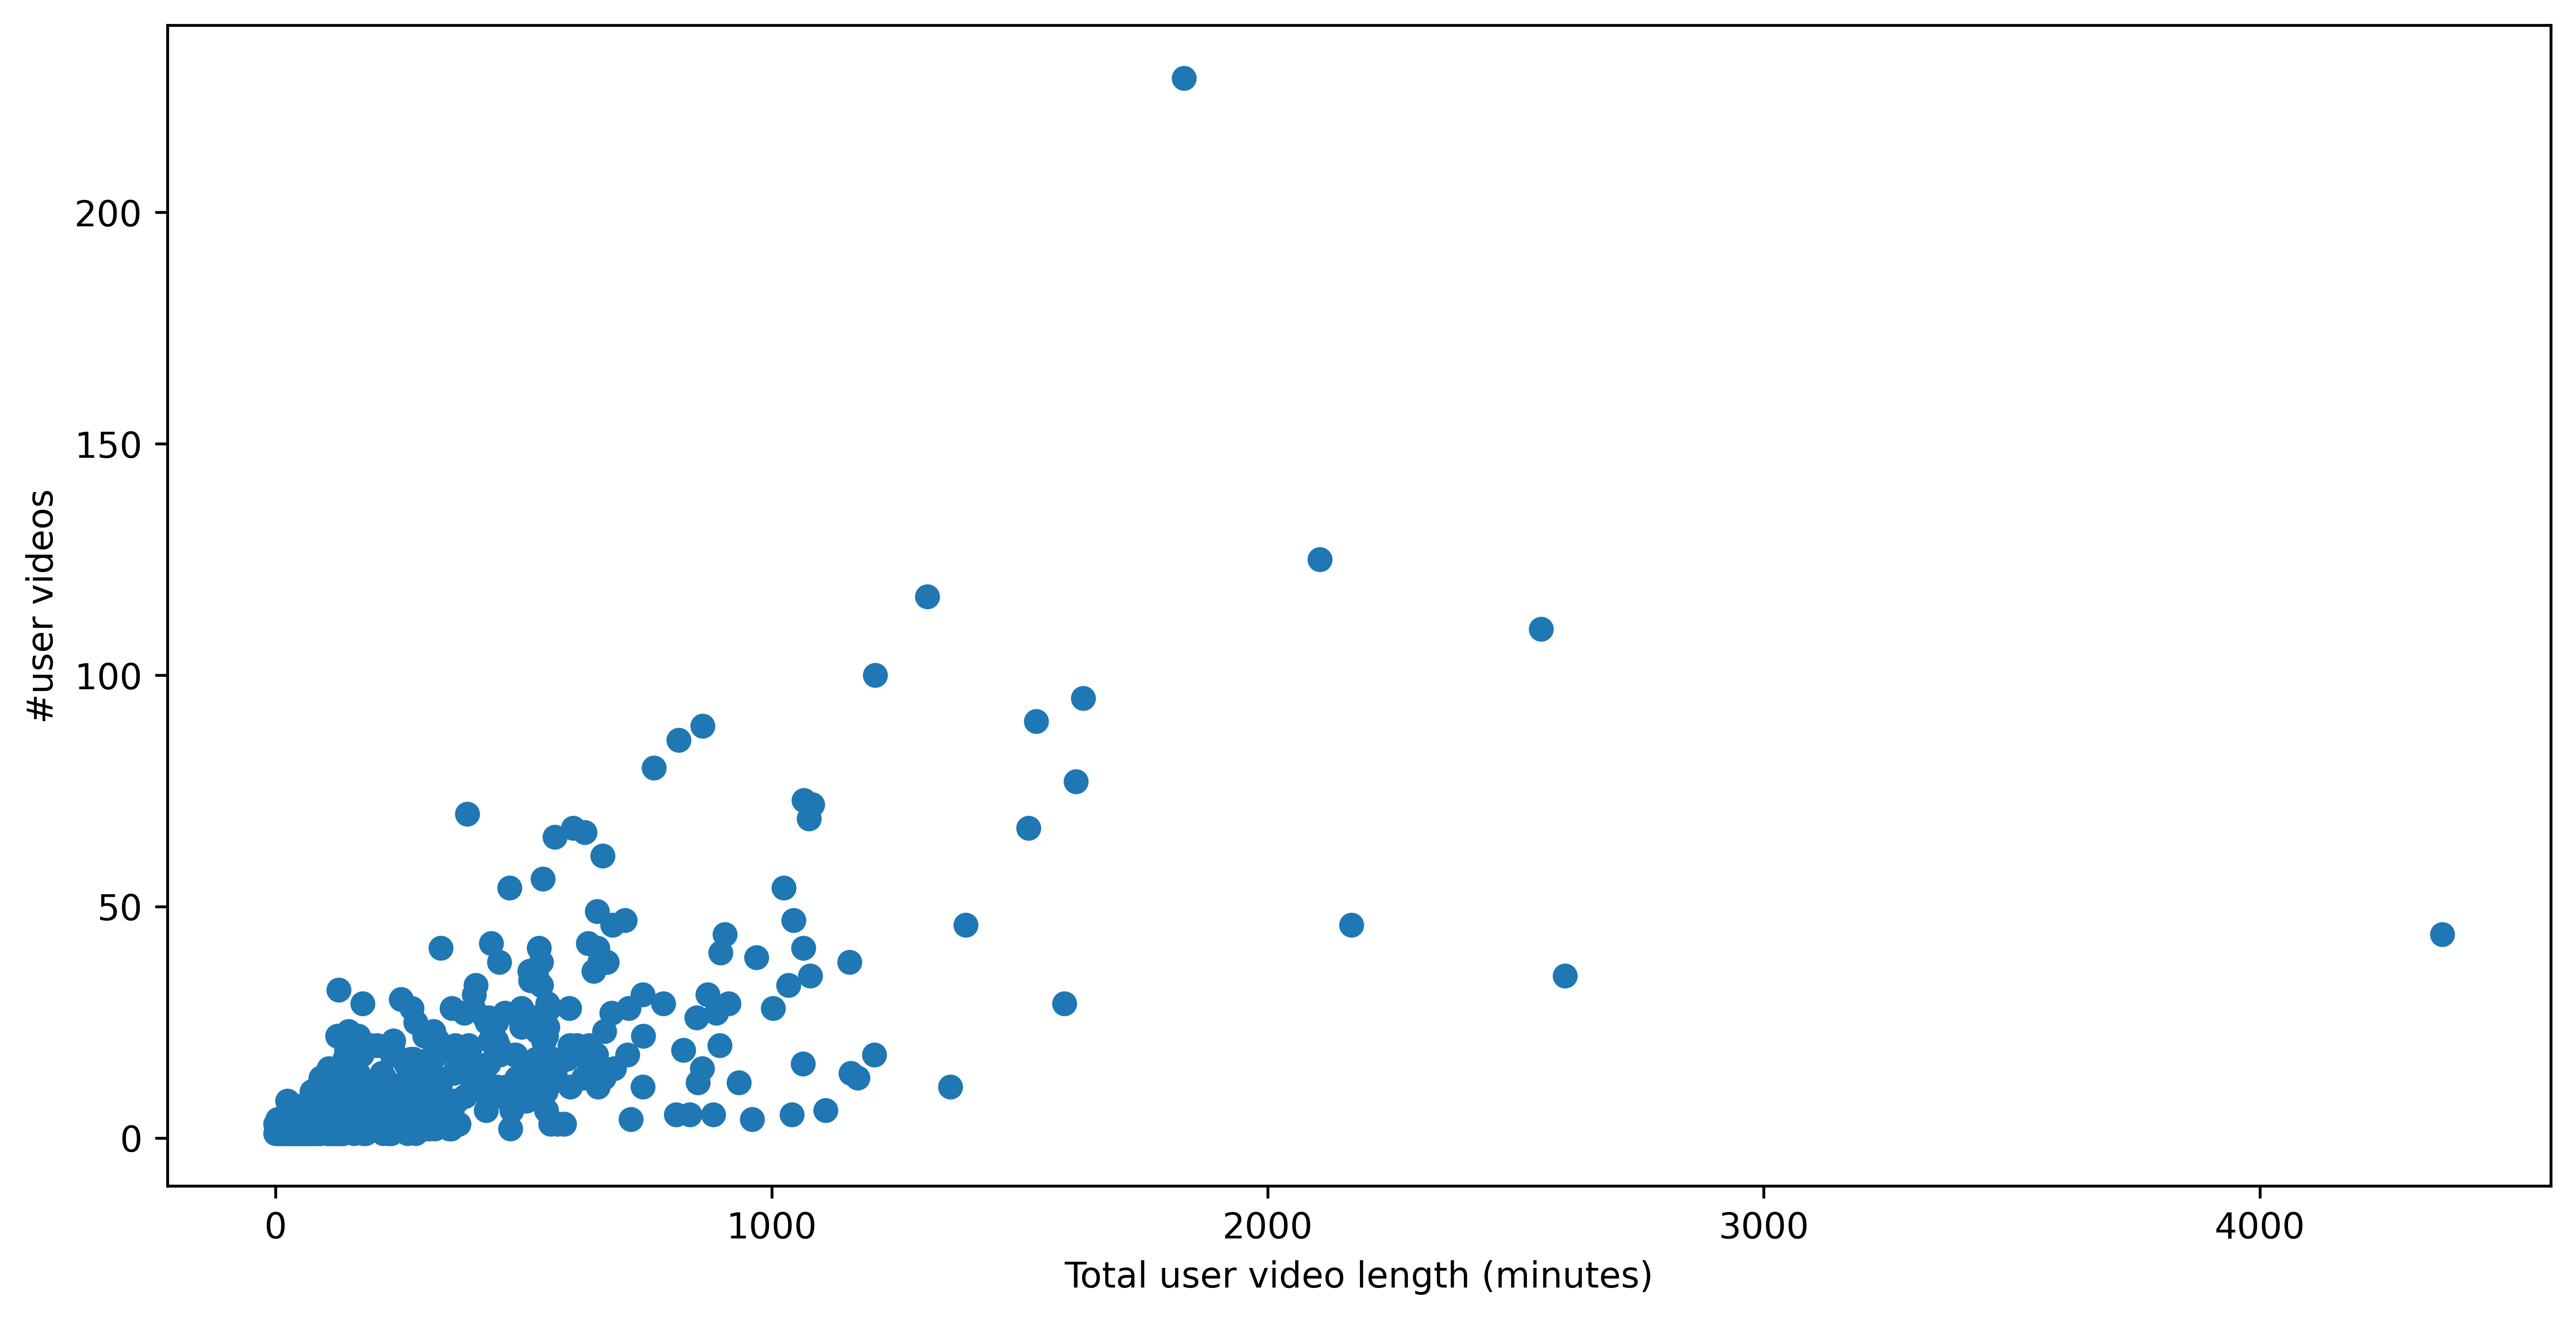

<Figure size 432x288 with 0 Axes>

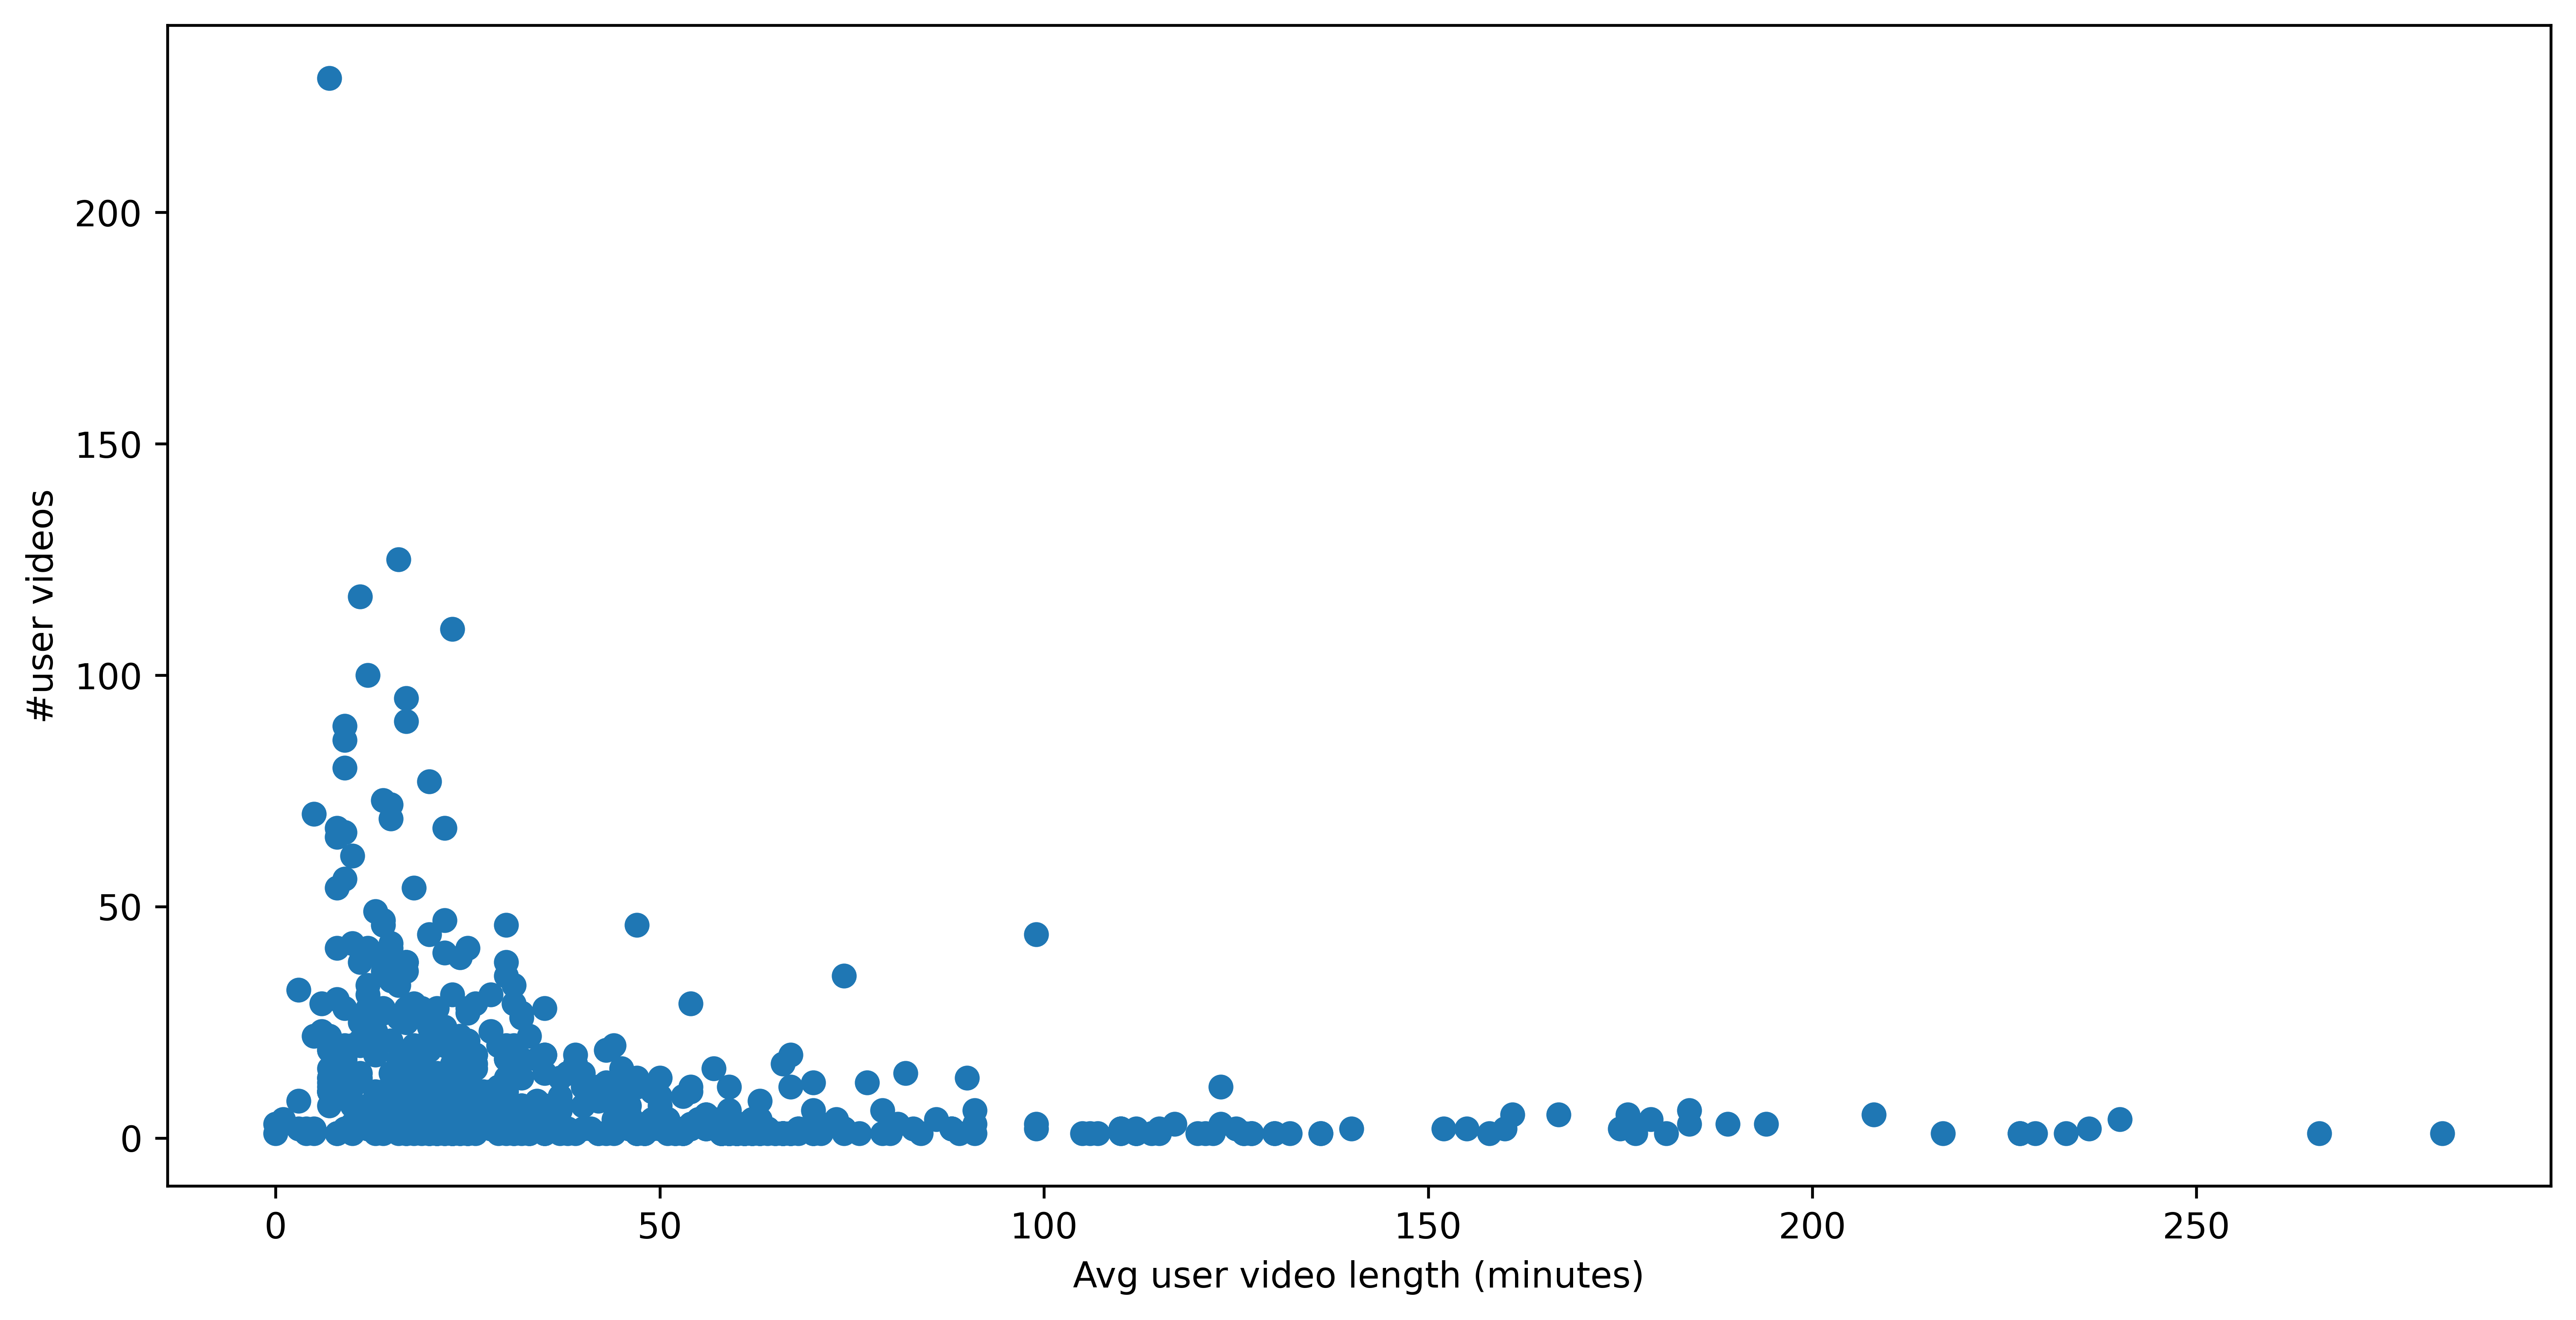

2 user profiles:
1) Take 1 to a few long videos (> 50min)
2) Take many (>25) shorter videos (< 50min)


<Figure size 432x288 with 0 Axes>

In [13]:
# Scatterplots: Nb of videos VS Total or avg video length /user

def plot_scatter(x, y, title,ylabel,xlabel, grid=False):
#     max_val = max(y)
    my_cmap = plt.get_cmap("plasma")
    plt.figure(figsize=(12, 6), dpi=600) # So all bars are visible!
    plt.scatter(x,y,cmap=my_cmap)
#     plt.ylim(None,max_val*1.01)
#     plt.xlim(None,None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
#     print(f"HEAD = {nb_format(y[:10])}...")
#     print(f"TAIL = ...{nb_format(y[-10:])}")
    
# Array of vid lengths, derive stats after
user_nb_videos = [len(vids_len_list) for vids_len_list in user_vid_sec_lists]

plot_scatter(user_totals,user_nb_videos,title="",ylabel="#user videos",xlabel="Total user video length (minutes)")
plot_scatter(user_avgs,user_nb_videos,title="",ylabel="#user videos",xlabel="Avg user video length (minutes)")
print(f"2 user profiles:")
print("1) Take 1 to a few long videos (> 50min)")
print("2) Take many (>25) shorter videos (< 50min)")

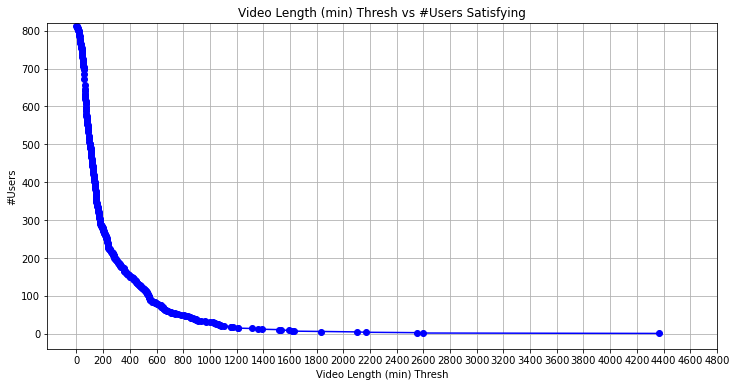

HEAD = [4368, 2599, 2551, 2169, 2105, 1831, 1628, 1613, 1590, 1533]...
TAIL = ...[16, 14, 13, 11, 10, 8, 6, 5, 4, 0]


<Figure size 432x288 with 0 Axes>

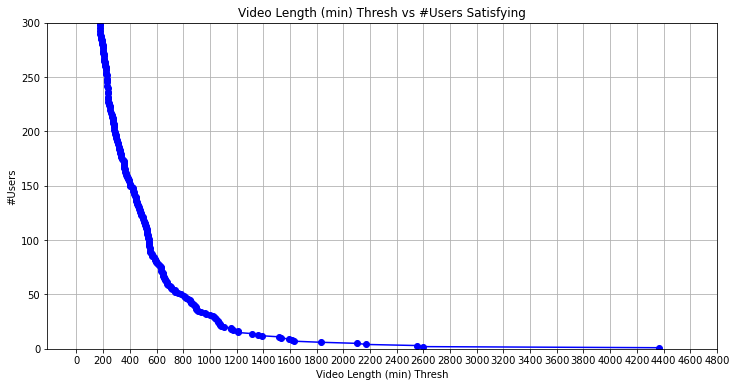

HEAD = [4368, 2599, 2551, 2169, 2105, 1831, 1628, 1613, 1590, 1533]...
TAIL = ...[16, 14, 13, 11, 10, 8, 6, 5, 4, 0]


<Figure size 432x288 with 0 Axes>

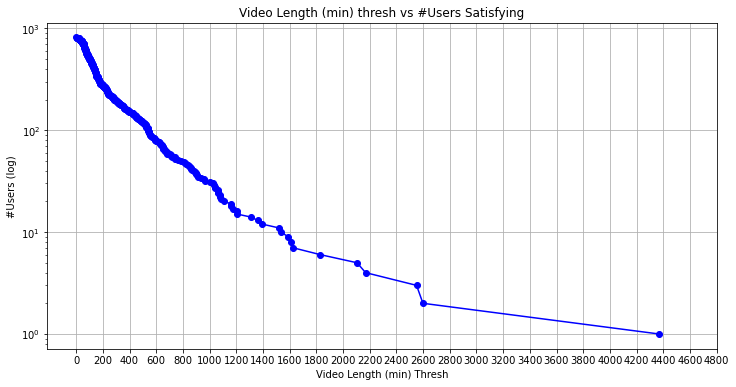

HEAD = [4368, 2599, 2551, 2169, 2105, 1831, 1628, 1613, 1590, 1533]...
TAIL = ...[16, 14, 13, 11, 10, 8, 6, 5, 4, 0]


<Figure size 432x288 with 0 Axes>

In [22]:
# Video total length threshold vs users satisfying
# NOT INCLUDING unassigned vids
import math

# Array of vid lengths, derive stats after
user_vid_sec_lists = [[v['duration_sec'] for v in u.videos] for k, u in user_dict.items() if k not in non_int_users]
user_total_mins = sorted([int(sum(vids_len_list)/60) for vids_len_list in user_vid_sec_lists],reverse=True) # total in minutes
min_val, max_val = user_total_mins[-1], user_total_mins[0]


def plot_line(x_axis, vals, title,ylabel,xlabel, grid=False,log=False,ylim=(None,None)):
    max_val = max(vals)
#     my_cmap = plt.get_cmap("plasma")
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x_axis, vals,color='b',marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log:
        plt.yscale('log')
    else:
        plt.ylim(None,max_val*1.01)
    
    x_major_ticks = list(range(0,5000,200))
    ax.set_xticks(x_major_ticks)
#     ax.set_yticks(major_ticks)

    plt.ylim(ylim)
    plt.title(title)
    plt.grid(grid)
    plt.show()
    plt.clf()
    
    print(f"HEAD = {nb_format(x_axis[:10])}...")
    print(f"TAIL = ...{nb_format(x_axis[-10:])}")

# Count unique vid-counts
unique_vidcnt_freqs = []
user_idx = 0
while user_idx < len(user_total_mins):
    new_vidcnt = user_total_mins[user_idx]
    nb_users = 1
    
    while user_idx + 1 < len(user_total_mins) and user_total_mins[user_idx + 1] == new_vidcnt:
        nb_users+=1
        user_idx+=1
    
    unique_vidcnt_freqs.append((new_vidcnt, nb_users))
    user_idx+=1 # Next unique vid count

# Now count how many users satisfy threshold, going from highest unique cnts to lowest
# Like CDF, the previous higher ones also satisfy this unique new threshold
unique_vidcnt_cum = [unique_vidcnt_freqs[0]]
for (new_vidcnt, nb_users) in unique_vidcnt_freqs[1:]:
    cum_users = unique_vidcnt_cum[-1][1] + nb_users
    unique_vidcnt_cum.append((new_vidcnt,cum_users))

x_vals = [x[0] for x in unique_vidcnt_cum]
y_vals = [x[1] for x in unique_vidcnt_cum]

plot_line(x_vals,y_vals,title="Video Length (min) Thresh vs #Users Satisfying",xlabel="Video Length (min) Thresh",ylabel="#Users",grid=True)

# ZOOM
plot_line(x_vals,y_vals,ylim=(0,300),title="Video Length (min) Thresh vs #Users Satisfying",xlabel="Video Length (min) Thresh",ylabel="#Users",grid=True)

# LOG variant
# log_y_vals = [math.log10(y) for y in y_vals]
plot_line(x_vals,y_vals,title="Video Length (min) thresh vs #Users Satisfying",xlabel="Video Length (min) Thresh",ylabel="#Users (log)",grid=True,log=True)
